In [982]:
import requests

def verify_entity_google_search(entity_name, api_key, cx):
    """
    Verifies if a named entity exists using Google's Custom Search API.
    
    Args:
    - entity_name (str): The name of the entity to check.
    - api_key (str): Your Google API Key.
    - cx (str): Your Custom Search Engine ID (CX).
    
    Returns:
    - bool: True if the entity exists, False otherwise.
    """
    # URL for Google Custom Search API
    url = f"https://www.googleapis.com/customsearch/v1?q={entity_name}&key={api_key}&cx={cx}"
    
    # Send request to the API
    response = requests.get(url).json()
    
    # Check if the 'items' key exists in the response (meaning search results were found)
    if 'items' in response:
        # If we get search results, the entity likely exists
        return True
    else:
        # No results, the entity might not exist or isn't prominent enough
        return False

# Example usage
api_key = "YOUR_GOOGLE_API_KEY"  # Replace with your actual API key
cx = "YOUR_CUSTOM_SEARCH_ENGINE_ID"  # Replace with your actual CSE ID

entity_name = "Tesla"
exists = verify_entity_google_search(entity_name, api_key, cx)
print(f"Entity '{entity_name}' exists in Google search: {exists}")


Entity 'Tesla' exists in Google search: False


<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Getting dataset from <a href = https://www.kaggle.com/competitions/nlp-getting-started/data style="text-decoration: underline; color : Default">kaggle</a>
</span>

In [984]:
# Import necessary modules for file handling and Kaggle operations
import os       
import shutil    
import zipfile  # Handle ZIP archive files
import kaggle   # Kaggle API client for downloading datasets

# Print the location of the installed kaggle package
print(kaggle.__file__)
# Download dataset using the Kaggle API
!kaggle competitions download -c nlp-getting-started

file_name = os.path.join(os.getcwd(), 'nlp-getting-started.zip')  # Get full path to the ZIP file
if os.path.exists(file_name):  # Check if the file exists
    with zipfile.ZipFile(file_name, 'r') as zip_f:  # Open ZIP file in read mode
        zip_f.extractall(os.getcwd())  # Extract all files to current directory
    print('Extraction completed')  # Confirm extraction
else:
    print(f'"{file_name}" does not exist. Download dataset from https://www.kaggle.com/competitions/nlp-getting-started/data')  # File not found message

/usr/local/anaconda3/lib/python3.12/site-packages/kaggle/__init__.py
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Extraction completed


<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Data Preprocessing
</span>

In [986]:
# Install the pyxDamerauLevenshtein package for calculating string distance using the Damerau-Levenshtein algorithm
!pip install pyxDamerauLevenshtein
# Install the fuzzywuzzy package for fuzzy string matching
!pip install fuzzywuzzy

In [987]:
from textblob import TextBlob  # For sentiment analysis
from collections import Counter  # For counting frequencies
import re  # For text cleaning using regular expressions 
import spacy  # For natural language processing
from unidecode import unidecode  # For Unicode normalization  
import pandas as pd 
from IPython.display import display, Markdown

In [988]:
#!python -m spacy download en_core_web_sm 
#!python -m spacy download en_core_web_md 
#!pip install pyspellchecker

In [989]:
# Load spaCy's language model for advanced NLP features
import spacy
nlp = spacy.load('en_core_web_sm') 

# Define custom stop words that are specific to the context of tweets
custom_stop_words = { 
   'tweets', 'retweet', 'retweets', 'follow', 'following',
    'follower', 'followers', 'dm', 'directmessage', 'hashtag', 'amp', 'via', 'twitter'
}   

# Combine NLTK stopwords, custom stopwords, and spaCy's stopwords into a comprehensive set
combined_stop_words = custom_stop_words.union(nlp.Defaults.stop_words)


In [990]:
print(f"Spacy vocabulary length is: {len(nlp.vocab.strings ) }")#check spacy vocabulary size

Spacy vocabulary length is: 84780


In [991]:
import pandas as pd

class DataHandler:
    def __init__(self, train_files, test_file=None, text_column='text'):
        """
        Initialize the DataHandler class.

        :param train_files: List of file paths for training data.
        :param test_file: File path for test data (optional).
        :param text_column: Name of the text column in the dataset.
        """
        self.train_files = train_files  # List of file paths for training data.
        self.test_file = test_file  # File path for test data.
        self.text_column = text_column  # Text column name.
        self.train_data = None  # Placeholder for the combined training data.
        self.test_data = None  # Placeholder for the test data.

    def load_data(self):
        """
        Load and concatenate training data from multiple files.
        Load the test data separately if provided.
        """
        # Load and concatenate training data
        train_dataframes = []
        for file in self.train_files:
            try:
                df = pd.read_csv(file)
                train_dataframes.append(df)
                print(f"Loaded training file: {file}, Shape: {df.shape}")
            except Exception as e:
                print(f"Error loading training file {file}: {e}")
        
        try:
            self.train_data = pd.concat(train_dataframes, ignore_index=True)
            print(f"All training data concatenated successfully. Shape: {self.train_data.shape}")
        except Exception as e:
            print(f"Error concatenating training data: {e}")
        
        # Load test data if provided
        if self.test_file:
            try:
                self.test_data = pd.read_csv(self.test_file)
                print(f"Test data loaded successfully. Shape: {self.test_data.shape}")
            except Exception as e:
                print(f"Error loading test data: {e}")

    def validate_train_data(self):
        """
        Validate the loaded training data and output metadata summaries.
        """
        if self.train_data is None:
            print("No training data loaded. Please load the training data first.")
            return

        print(f"Training Data Shape: {self.train_data.shape}")
        print(f"Columns: {self.train_data.columns.tolist()}")
        print("Data Types:")
        print(self.train_data.dtypes)
        print("Missing Values:")
        print(self.train_data.isnull().sum())
        print("Sample Training Data:")
        print(self.train_data.head())

    def validate_test_data(self):
        """
        Validate the loaded test data and output metadata summaries.
        """
        if self.test_data is None:
            print("No test data loaded. Please load the test data first.")
            return

        print(f"Test Data Shape: {self.test_data.shape}")
        print(f"Columns: {self.test_data.columns.tolist()}")
        print("Data Type")
        print(self.test_data.dtypes)
        print("Missing Values:")
        print(self.test_data.isnull().sum())
        print("Sample Test Data:")
        print(self.test_data.head())


In [992]:
import spacy
import re
import pandas as pd
import random
from spacy.language import Language
import matplotlib.pyplot as plt

class TextProcessor:
    def __init__(self, stages=[]):
        self.nlp = spacy.load("en_core_web_sm")
        self.stop_words = self.nlp.Defaults.stop_words
        self.valid_words = set(self.nlp.vocab.strings)
        self.stages = stages
        
        self.patterns = {
            'HASHTAG': re.compile(r'#\w+'),
            'USERNAME': re.compile(r'@\w+'),
            'TWITTER_URL': re.compile(r'https?://t.co/\S+'),
            'TELEGRAM_URL': re.compile(r'https?://t.me/\S+'),
            'WEB_URL': re.compile(r'https?://www\.\S+')
        }
        self.date_patterns = [
            r'\b(?:\d{1,2}[./-]\d{1,2}[./-]\d{2,4})\b',
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2},? \d{4}\b',
            r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) \d{1,2},? \d{4}\b',
            r'\b\d{4}-(?:0[1-9]|1[0-2])-(?:0[1-9]|[12][0-9]|3[01])\b',
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December) \d{4}\b',
            r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) \d{4}\b',
            r'\b(?:0?[1-9]|[12][0-9]|3[01])-(?:January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{4}\b',
            r'\b\d{4} (?:January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}\b',
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b',
            r'\b(?:19[0-9]{2}|20[0-9]{2})\b',
            r'\b(?:\d{1,2}(?:st|nd|rd|th)? (?:January|February|March|April|May|June|July|August|September|October|November|December),? \d{4})\b',
            r'\b(?:\d{1,2}(?:st|nd|rd|th)? of (?:January|February|March|April|May|June|July|August|September|October|November|December),? \d{4})\b'
        ]

        
        self.regex_filter_patterns = [ 
            r'https?://\S+|www\.\S+',            # Drop all links (URLs).
            r'#(?!\S)',                          # Drop standalone hashtags (e.g., #).
            r'\b\d+\b',                          # Drop standalone numbers.
            r'\b(\w)\1{1,}\b',                   # Drop standalone two-letter words with repeating letters (e.g., "aa").
            r'[^\w\s#@]',                        # Replace non-alphanumeric characters with space (already done).
            r'(?<!\S)\b\w{1,2}\b(?!\S)',         # Drop single-letter or two-letter words.
            r'[^\x00-\x7F]',                     # Drop non-ASCII characters.
            r'(?<=\w)[^\w#@]+(?=\s|$)',          # Remove unwanted characters following words, hashtags, or mentions.
        ]


        
        self._add_custom_components()

    def _ensure_text(self, input_data):
        """Ensure input is in string format for uniform processing."""
        if isinstance(input_data, list):
            return ' '.join(input_data)  # Join list into a single string
        return input_data

    def apply_regex_filter(self, text):
        """Apply all regex patterns to input text recursively until no further changes."""
        text = self._ensure_text(text)
        cleaned_text = text
        previous_text = ""
        
        while cleaned_text != previous_text:  # Keep cleaning until text stops changing
            previous_text = cleaned_text
            for pattern in self.regex_filter_patterns:
                cleaned_text = re.sub(pattern, ' ', cleaned_text)  # Replace matches with space
        
        return cleaned_text.split()  # Return a list of words

    def remove_stopwords(self, tokens):
        """Remove stopwords from the list of tokens and return only unique tokens."""
        if isinstance(tokens, str):
            tokens = tokens.split()  # If input is string, split it into tokens
        return [word.lower() for word in tokens if word not in self.stop_words]

    def drop_mentions(self, text):
        """Remove username mentions from the input text."""
        text = self._ensure_text(text)
        pattern = r'@\w+'
        cleaned_text = re.sub(pattern, '', text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        return cleaned_text.lower().split()  # Return as list of tokens

    def drop_hashtags(self, text):
        """Remove hashtags from the input text."""
        text = self._ensure_text(text)
        pattern = r'#\S+'
        cleaned_text = re.sub(pattern, '', text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        return cleaned_text.lower().split()  # Return as list of tokens

    def filter_valid_tokens(self, tokens):
        """Filter out invalid tokens based on word rules, keeping valid usernames starting with @."""
        if isinstance(tokens, str):
            tokens = tokens.split()  # If input is string, split it into tokens
    
        # Regex pattern for a valid username: starts with '@', followed by letters, numbers, or underscores
        username_pattern = r"^@[a-zA-Z0-9_]+$"
        
        return [
            token.lower() for token in tokens
            if (
                # Keep tokens that match the valid username pattern (starting with '@')
                re.match(username_pattern, token)
                or
                # Keep valid words with letters and numbers (e.g., 'word123')
                (re.match(r"^[a-zA-Z]+[0-9]*$", token) and re.findall(r'[a-zA-Z]+', token)[0] in self.valid_words)
                or
                # Keep tokens starting with '#' followed by letters and numbers (e.g., '#hashtag')
                (token.startswith("#") and re.match(r"^[#][a-zA-Z]+[0-9]*$", token))
            )
        ]
 
    def apply_tweet_tokenizer(self, text):
        """Tokenize a tweet into relevant components: words, hashtags, mentions, and URLs."""
        # Define regex patterns for tweet-specific tokenization
        tweet_tokens = re.findall(r'(\#\w+|\@\w+|https?://\S+|\w+)', text)
        return tweet_tokens


    def process_text(self, text):
        """Process text using spaCy pipeline and active filters."""
        text = self._ensure_text(text)  # Ensure the input is a string
        doc = self.nlp(text)
        cleaned_tokens = [token.text for token in doc]
        
        # Apply custom tokenizer if specified in stages
        if "tweet_tokenize" in self.stages:
            cleaned_tokens = self.tweet_tokenizer(" ".join(cleaned_tokens))
        
        if "apply_regex_filter" in self.stages:
            cleaned_tokens = self.apply_regex_filter(" ".join(cleaned_tokens))
        if "remove_stopwords" in self.stages:
            cleaned_tokens = self.remove_stopwords(cleaned_tokens)
        if "filter_valid_tokens" in self.stages:
            cleaned_tokens = self.filter_valid_tokens(cleaned_tokens)
        if "drop_mentions" in self.stages:
            cleaned_tokens = self.drop_mentions(" ".join(cleaned_tokens))
        if "drop_hashtags" in self.stages:
            cleaned_tokens = self.drop_hashtags(" ".join(cleaned_tokens))

        return cleaned_tokens



    def _add_custom_components(self):
        @Language.component("regex_matcher")
        def regex_matcher(doc):
            matches = []
            for label, pattern in self.patterns.items():
                for match in pattern.finditer(doc.text):
                    span = doc.char_span(match.start(), match.end(), label=label)
                    if span:
                        matches.append((label, span.text))
            doc._.custom_matches = matches
            return doc
        
        @Language.component("date_extractor")
        def date_extractor(doc):
            raw_dates = []
            combined_pattern = '|'.join(self.date_patterns)
            for match in re.findall(combined_pattern, doc.text):
                raw_dates.append(match)
            doc._.raw_dates = raw_dates
            doc._.raw_date = random.choice(raw_dates) if raw_dates else None

            doc._.date_info = self.convert_to_datetime(doc._.raw_date)
            return doc

        
        @Language.component("token_cleaner")
        def token_cleaner(doc):
            tokens = [token.text for token in doc]

                        
            # Run remove_stopwords only if it's in active_components
            if "apply_regex_filter" in self.stages:
                tokens = self.apply_regex_filter(tokens)
                        
            # Run remove_stopwords only if it's in active_components
            if "remove_stopwords" in self.stages:
                tokens = self.remove_stopwords(tokens)
            
            # Run filter_valid_tokens only if it's in active_components
            if "filter_valid_tokens" in self.stages:
                tokens = self.filter_valid_tokens(tokens)
                
            # Run drop_mentions only if it's in active_components
            if "drop_mentions" in self.stages:
                tokens = self.drop_mentions(tokens)
            
            # Run drop_hashtags only if it's in active_components
            if "drop_hashtags" in self.stages:
                tokens = self.drop_hashtags(tokens)
            
            doc._.cleaned_tokens = tokens
            return doc

        # Add custom extensions to store cleaned tokens
        if not spacy.tokens.Doc.has_extension("cleaned_tokens"):
            spacy.tokens.Doc.set_extension("cleaned_tokens", default=[])
        # Add custom extensions
        if not spacy.tokens.Doc.has_extension("custom_matches"):
            spacy.tokens.Doc.set_extension("custom_matches", default=[])
        if not spacy.tokens.Doc.has_extension("raw_dates"):
            spacy.tokens.Doc.set_extension("raw_dates", default=[])
        if not spacy.tokens.Doc.has_extension("raw_date"):
            spacy.tokens.Doc.set_extension("raw_date", default=None)
        if not spacy.tokens.Doc.has_extension("date_info"):
            spacy.tokens.Doc.set_extension("date_info", default=(None, None)) 
        if not spacy.tokens.Doc.has_extension("cleaned_tokens"):
            spacy.tokens.Doc.set_extension("cleaned_tokens", default=[])

        # Add components to pipeline 
        self.nlp.add_pipe("token_cleaner", first=True)
        self.nlp.add_pipe("regex_matcher", last=True)
        self.nlp.add_pipe("date_extractor", last=True)


    def convert_to_datetime(self, raw_date):
        if not raw_date:
            return float('nan'), float('nan')
        
        try:
            date = pd.to_datetime(raw_date, format='%d/%m/%Y')
            return date, 'full'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%d-%m-%Y')
            return date, 'full'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%B, %d %Y')
            return date, 'full'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%B %d %Y')
            return date, 'full'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%B %Y')
            date = date.replace(day=1)  # impute day
            return date, 'month and year'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%B')
            return date, 'month'
        except ValueError:
            pass
        try:
            date = pd.to_datetime(raw_date, format='%Y')
            date = date.replace(day=1, month=1)
            return date, 'year'
        except ValueError:
            pass

        return float('nan'), float('nan')

    def process_text(self, text):
        doc = self.nlp(text)
        cleaned_tokens = doc._.cleaned_tokens
        regex_matches = [(label, match) for label, match in doc._.custom_matches]
        named_entities = [(ent.label_, ent.text) for ent in doc.ents]
        raw_dates = doc._.raw_dates
        date_info = doc._.date_info
    
        # Combine regex matches and named entities
        all_entities = regex_matches + named_entities
    
        # Group entities by their labels into a dictionary
        entity_dict = {}
        for label, value in all_entities:
            if label not in entity_dict:
                entity_dict[label] = []
            entity_dict[label].append(value)
    
        # Return the processed results
        return cleaned_tokens, entity_dict, raw_dates, date_info



    def count_entity_label(self, row, entity_label):
        # Retrieve the dictionary of entities for the row
        entities_dict = row['entities']
    
        # Count the occurrences of the specified entity label
        return len(entities_dict.get(entity_label, []))

    def add_entity_counts(self, df):
        # First, create a new column containing all entities for each row
        df['entities'] = df['text'].apply(lambda x: self.process_text(x)[1])  # Assuming process_text returns entities as 2nd element
    
        # Extract unique entity labels across the entire DataFrame
        entity_labels = set()
        for entities_dict in df['entities']:
            entity_labels.update(entities_dict.keys())
    
        # Sort entity labels to ensure consistent column ordering
        entity_labels = sorted(entity_labels)
    
        # Now create a column for each entity label to count occurrences
        for entity_label in entity_labels:
            column_name = f"{entity_label.lower()}_count"
            df[column_name] = df['entities'].apply(
                lambda entities_dict: len(entities_dict.get(entity_label, []))
            )
    
        return df

        
    def add_date_counts(self, df):
        df['year_or_month_count'] = df['raw_dates'].apply(lambda x: sum([1 for date in x if len(date.split()) <= 2]))
        df['full_date_count'] = df['raw_dates'].apply(lambda x: sum([1 for date in x if len(date.split()) == 3]))
        return df
 
    def process_dataframe(self, df):
        df['cleaned_tokens'], df['entities'], df['raw_dates'], df['date_info'] = zip(
            *df['text'].map(self.process_text)
        )
        df["date_month"], df["date_year"] = zip(*df["date_info"])
        df = self.add_entity_counts(df)
        df = self.add_date_counts(df)        
        return df


    def apply_stages_incrementally(self, df, text_column):
        """
        Apply the stages incrementally and add a column for each stage with the name f'stage{i}'.
        Generate a bar plot for the count of unique tokens after each filtering stage,
        with the value of each bar displayed on top.
    
        :param df: Input DataFrame containing the text data.
        :param text_column: The name of the column containing the input text.
        :return: DataFrame with additional columns for each stage.
        """
        # Lists to hold data for plotting
        filter_steps = []
        unique_token_counts = []
        
        for i, stage in enumerate(self.stages, start=1):
            # Check if the stage is a valid method in the class
            if hasattr(self, stage):
                method = getattr(self, stage)
                # Apply the method for the current stage and create a new column with name f'stage{i}'
                new_column_name = f'stage{i}'
                df[new_column_name] = df[text_column].apply(method)
                
                # Collect data for plotting
                filter_steps.append(new_column_name)
                tokens = df[new_column_name].explode().dropna().tolist()  # Flatten tokens for counting
                unique_token_counts.append(len(set(tokens)))  # Count unique tokens
                
                # Update the text_column to reflect the latest processing stage
                text_column = new_column_name
            else:
                # If the stage is not a valid method, raise an error
                raise ValueError(f"Stage '{stage}' is not a valid method.")
        
        # Create a figure for the bar chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Adjust bar width to reduce space between bars
        bar_width = 0.4  # Reduce bar width to make bars thinner
        x_positions = range(len(filter_steps))  # Set the x positions for the bars directly adjacent
        
        # Make sure bars are placed directly on top of each other by setting width
        bars = ax.bar(x_positions, unique_token_counts, color='skyblue', width=bar_width)
        
        # Annotate each bar with its value on top
        for bar in bars:
            yval = bar.get_height()  # Get the height (value) of the bar
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # x position (center of the bar)
                yval,  # y position (top of the bar)
                f'{yval}',  # Text to display (value of the bar)
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10  # Font size for the annotation
            )
        
        # Customize the plot
        ax.set_xlabel('Filtering Steps')
        ax.set_ylabel('Count of Unique Tokens')
        ax.set_title('Count of Unique Tokens After Each Filtering Step')
        
        # Set x-tick labels to the names of the filtering steps
        ax.set_xticks(x_positions)
        ax.set_xticklabels(filter_steps)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
    
        # Adjust the layout to avoid overlap and make the plot more compact
        plt.tight_layout()
        plt.show()
        
        return df

        

In [993]:
#!pip install emoji
#!python -m textblob.download_corpora

In [994]:
import nltk
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from emoji import is_emoji

# Ensure that necessary NLTK data is downloaded
nltk.download('punkt')

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/AlbertLeo1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [995]:

class TokenPipeline:
    def __init__(self, train_files, test_file=None, stages=None, text_column="text", target_column=None):
        self.loader = DataHandler(train_files=train_files, test_file=test_file)
        self.loader.load_data()  # Load the data using DataHandler
        
        self.train_data = self.loader.train_data
        self.test_data = self.loader.test_data
        self.target_column = target_column  # Add target_column here
        
        self.stages = stages if stages else [
            "apply_tweet_tokenizer",  
            "apply_regex_filter",
            "remove_stopwords",
            "filter_valid_tokens",
            "drop_mentions",
            "drop_hashtags",
        ]
        self.text_column = text_column
        self.feature_columns = []
        
        self.processor = TextProcessor(stages=self.stages)



    def apply_tweet_tokenizer(self, df):
        """
        Tokenizes the text column of the DataFrame using the Twitter tokenizer.
        This function is applied as a stage in the pipeline.
        
        Parameters:
        df (pd.DataFrame): The DataFrame containing the text column to tokenize.
        
        Returns:
        pd.DataFrame: The DataFrame with tokenized text.
        """
        tweet_tokenizer = TweetTokenizer()
        df[self.text_column] = df[self.text_column].apply(lambda x: tweet_tokenizer.tokenize(str(x)))
        return df


    def prepare_and_process_data(self):
        processed_train_data = self.processor.apply_stages_incrementally(self.train_data, self.text_column)
        self.processor.process_dataframe(processed_train_data)

        processed_test_data = None
        if self.test_data is not None:
            processed_test_data = self.processor.apply_stages_incrementally(self.test_data, self.text_column)
            self.processor.process_dataframe(processed_test_data)
            
        return processed_train_data, processed_test_data
    
    def extract_features(self):
        # Initialize feature columns
        self.feature_columns = [
            'text_length', 'word_count', 'exclamation_count', 'capitalized_words_pct', 
            'sentiment_polarity', 'sentiment_subjectivity', 'url_count', 
            'emoji_count', 'unique_word_count', 'noun_count', 'verb_count', 
            'adj_count', 'adverb_count', 'time_of_day', 'readability_score'
        ]
        
        # Extract features
        features = self.train_data[self.text_column].apply(self._extract_features_from_text)
        
        # Create DataFrame from the features list
        feature_df = pd.DataFrame(features.tolist(), columns=self.feature_columns)
        
        return feature_df 
    
    def _extract_features_from_text(self, text):
        text = str(text)  # Ensure it's a string
        doc = nlp(text)  # Process text using SpaCy

        text_length = len(text)
        word_count = len([token for token in doc if token.is_alpha])
        exclamation_count = text.count('!')

        capitalized_words = [token.text for token in doc if token.is_upper]
        capitalized_words_pct = len(capitalized_words) / word_count if word_count else 0

        sentiment_polarity = None  # Placeholder (SpaCy doesn't have built-in sentiment)
        sentiment_subjectivity = None

        url_count = len([token for token in doc if token.like_url])
        emoji_count = len([token.text for token in doc if is_emoji(token.text)])
        
        unique_word_count = len(set([token.text.lower() for token in doc if token.is_alpha]))
        
        noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
        verb_count = sum(1 for token in doc if token.pos_ == "VERB")
        adj_count = sum(1 for token in doc if token.pos_ == "ADJ")
        adverb_count = sum(1 for token in doc if token.pos_ == "ADV")

        time_of_day = None  # Placeholder (needs additional timestamp logic)

        syllables = sum(self._syllables_in_word(token.text) for token in doc if token.is_alpha)
        sentences = len(list(doc.sents))
        readability_score = 0
        if sentences > 0 and word_count > 0:
            readability_score = 0.39 * (word_count / sentences) + 11.8 * (syllables / word_count) - 15.59

        return [
            text_length, word_count, exclamation_count, capitalized_words_pct, 
            sentiment_polarity, sentiment_subjectivity, url_count, 
            emoji_count, unique_word_count, noun_count, verb_count, 
            adj_count, adverb_count, time_of_day, readability_score
        ]

    def _syllables_in_word(self, word):
        word = word.lower()
        vowels = "aeiouy"
        syllables = 0
        prev_char = ""

        for char in word:
            if char in vowels and prev_char not in vowels:
                syllables += 1
            prev_char = char

        if word.endswith('e'):
            syllables -= 1

        return max(syllables, 1)

    def move_count_columns(self, df):
        count_columns = [col for col in df.columns if col.endswith('count') or col in self.feature_columns]
        feature_df = df[count_columns].copy()
        df.drop(columns=count_columns, inplace=True)
        return df, feature_df

    def process_and_move_columns(self):
        processed_train_data, processed_test_data = self.prepare_and_process_data()
        train_tokens_df, train_entity_count_df = self.move_count_columns(processed_train_data)

        test_tokens_df, test_entity_count_df = None, None
        if processed_test_data is not None:
            test_tokens_df, test_entity_count_df = self.move_count_columns(processed_test_data)

        return (train_tokens_df, train_entity_count_df), (test_tokens_df, test_entity_count_df)

    @staticmethod
    def lemmatize_df(df, column_name, method='nltk'):
        """
        Applies lemmatization on the given DataFrame column based on the chosen method.
    
        Parameters:
        df (pd.DataFrame): The DataFrame with the text data.
        column_name (str): The name of the column containing text data.
        method (str): The lemmatization method to use ('nltk', 'spacy', 'simple').
    
        Returns:
        pd.DataFrame: The DataFrame with lemmatized tokens in the specified column.
        """
        # Ensure the column contains strings, and handle missing values
        df[column_name] = df[column_name].fillna('').astype(str)
    
        # Function to lemmatize text based on the selected method
        def lemmatize_text(text, method):
            # Tokenize text (if it's not already tokenized)
            tokens = text.split()  # split string into tokens by whitespace
            
            # Apply lemmatization to the tokens
            if method == 'nltk':
                lemmatizer = WordNetLemmatizer()
                return [lemmatizer.lemmatize(word) for word in tokens]
            
            elif method == 'spacy':
                nlp = spacy.load('en_core_web_sm')
                doc = nlp(' '.join(tokens))
                return [token.lemma_ for token in doc]
            
            elif method == 'simple':
                return [re.sub(r'(ing|ed|es|ly|s)$', '', word) for word in tokens]
            
            else:
                raise ValueError("Invalid method. Choose either 'nltk', 'spacy', or 'simple'.")
    
        # Apply the lemmatization to each entry in the column
        df[column_name] = df[column_name].apply(lambda x: lemmatize_text(x, method))
        
        return df



In [996]:
#feature_df = pipeline.extract_features() 
#train_tokens_df 

In [997]:
def process_and_plot(self):
    # Check if the dataframes are empty
    if self.train_tokens_df.empty:
        print("Warning: train_tokens_df is empty.")
    if self.feature_df.empty:
        print("Warning: feature_df is empty.")

    # Encode non-numeric columns in both train_tokens_df and feature_df (keeping original columns intact)
    train_tokens_df_encoded = self.encode_non_numeric(self.train_tokens_df)
    feature_df_encoded = self.encode_non_numeric(self.feature_df)

    # Calculate the correlation matrices for the encoded versions
    train_tokens_corr = self.calculate_correlation(train_tokens_df_encoded)
    feature_corr = self.calculate_correlation(feature_df_encoded)

    # Plot the heatmaps for both DataFrames
    self.plot_heatmap(train_tokens_corr, "Feature Correlation Matrix for train_tokens_df (Including Encoded Non-Numeric Features)")
    self.plot_heatmap(feature_corr, "Feature Correlation Matrix for feature_df")

    # Remove multicollinearity from both DataFrames and get the columns to drop
    dropped_train_tokens = self.remove_multicollinearity(self.train_tokens_df, train_tokens_corr)
    dropped_feature = self.remove_multicollinearity(self.feature_df, feature_corr)

    # Filter out columns from train_tokens_df that are dropped due to multicollinearity
    final_train_tokens_df = self.train_tokens_df.drop(columns=dropped_train_tokens, errors='ignore')

    # Filter out columns from feature_df that are dropped due to multicollinearity
    final_feature_df = self.feature_df.drop(columns=dropped_feature, errors='ignore')

    # If drop_stage_columns is True, drop the stage columns
    if self.drop_stage_columns:
        stage_columns = [col for col in final_feature_df.columns if 'stage' in col]
        if stage_columns:  # Ensure there are stage columns to drop
            final_feature_df = final_feature_df.drop(columns=stage_columns, errors='ignore')

    # Combine the two DataFrames into the final DataFrame with all valid columns
    combined_df = pd.concat([final_train_tokens_df, final_feature_df], axis=1)

    # Drop columns that contain only NaN values (i.e., columns with all None/NaN values)
    combined_df = combined_df.dropna(axis=1, how='all')

    # Display the results
    print(f"Dropped columns from train_tokens_df due to multicollinearity: {dropped_train_tokens}")
    print(f"Dropped columns from feature_df due to multicollinearity: {dropped_feature}")
    print(f"Remaining columns in train_tokens_df: {final_train_tokens_df.columns.tolist()}")
    print(f"Remaining columns in feature_df: {final_feature_df.columns.tolist()}")
    print("Combined DataFrame after removing multicollinearity and NaN-only columns:")

    return combined_df


Loaded training file: train.csv, Shape: (7613, 5)
All training data concatenated successfully. Shape: (7613, 5)
Test data loaded successfully. Shape: (3263, 4)


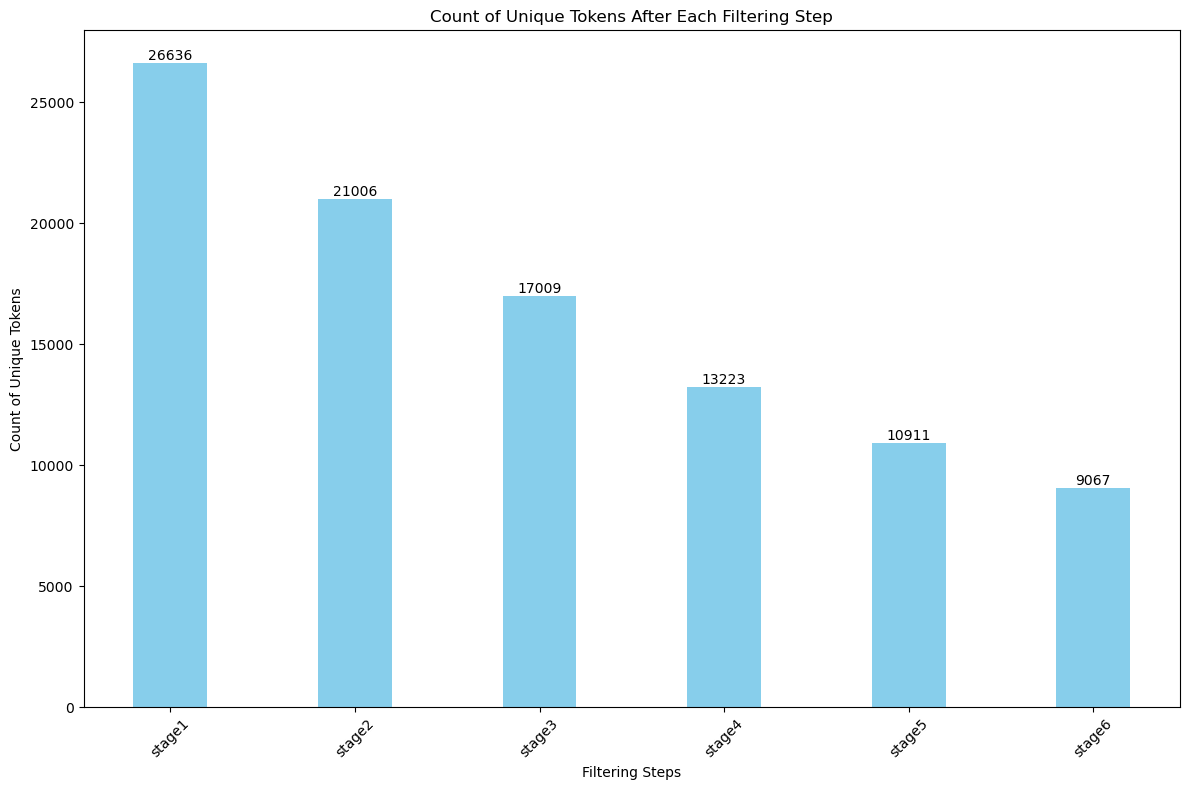

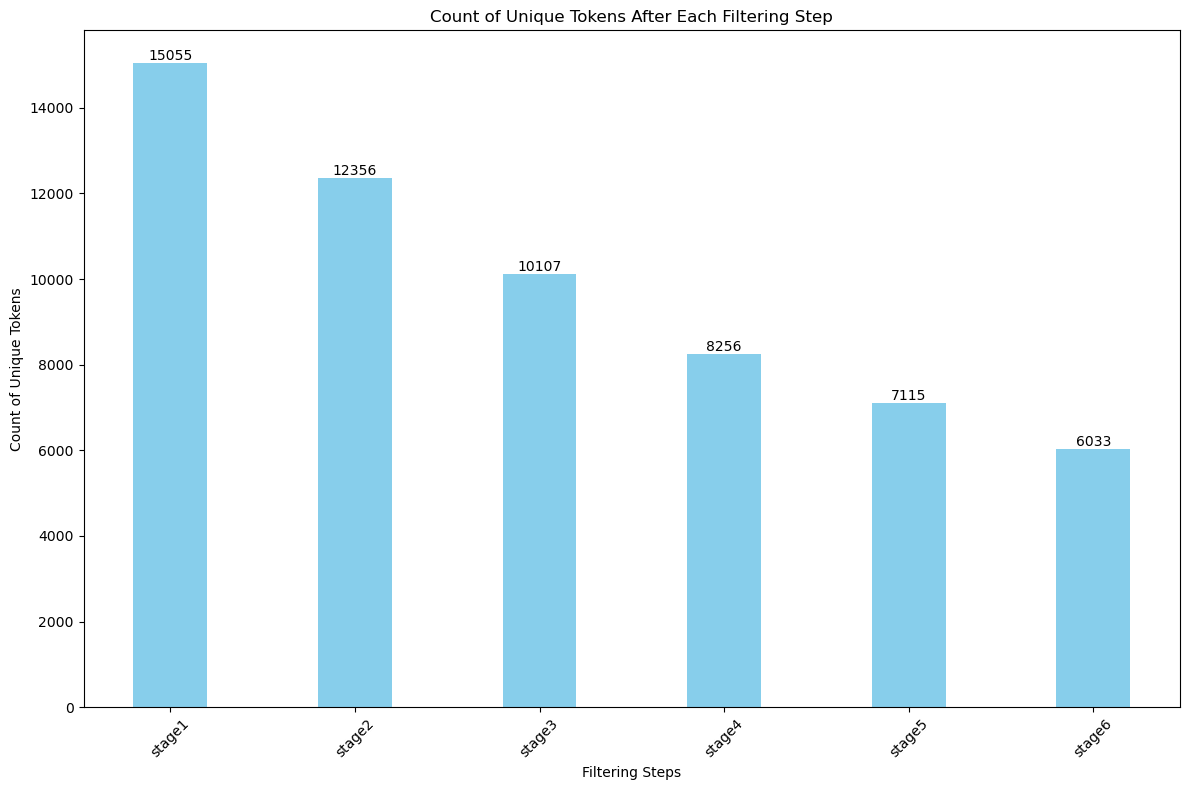

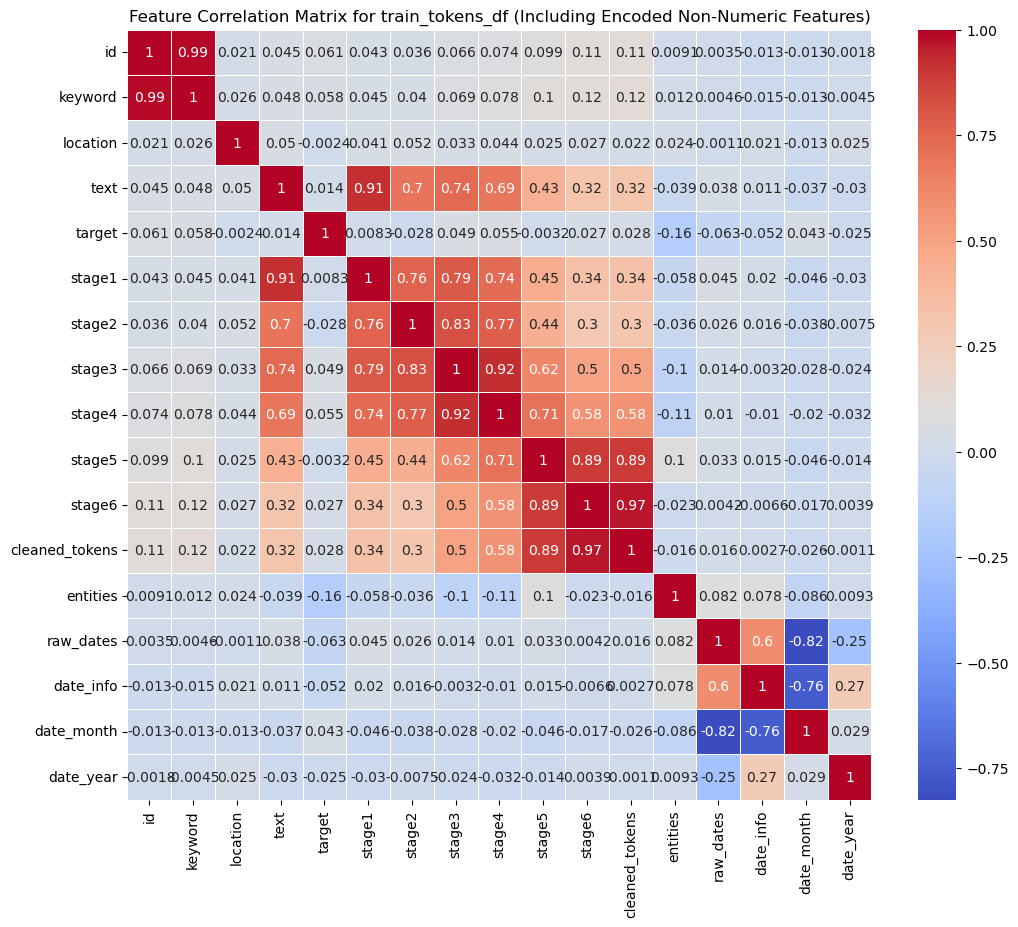

In [ ]:
class DataProcessor:
    def __init__(self, train_files, test_file=None, text_column='text', target_column='target'):
        self.train_files = train_files
        self.test_file = test_file
        self.text_column = text_column
        self.target_column = target_column

        # DataProcessingPipeline setup
        self.pipeline = TokenPipeline(
            train_files=train_files,
            test_file=test_file,
            text_column=text_column,
            target_column=target_column
        )
        
        # FeatureCorrelation setup (initialized later)
        self.feature_corr = None
        
        # Class-level variables for storing data
        self.train_data = None
        self.test_data = None
        self.feature_df = None
        self.combined_df = None
        self.dropped_columns = {
            'train_tokens': [],
            'feature': []
        }

    def execute_pipeline(self):

        # Step 2: Access the processed train and test data
        train_tokens, test_tokens = self.pipeline.process_and_move_columns()
        self.train_data = train_tokens[0] 
        self.test_data  = test_tokens[0]  

        # Step 3: Extract features from both train and test data (Ensure correct feature extraction)
        feature_df = self.pipeline.extract_features()  # Assuming this method extracts features from processed data

        # Step 4: Initialize FeatureCorrelation with processed data
        self.feature_corr = FeatureCorrelation(
            train_tokens_df=self.train_data,  # Use train tokens for correlation
            feature_df=feature_df,            # Use feature DataFrame from processed data
            target_column=self.target_column
        )

        # Step 5: Perform feature correlation and remove multicollinearity
        self.combined_df = self.feature_corr.process_and_plot()

        # Step 6: Store dropped columns due to multicollinearity
        self.dropped_columns['train_tokens'] = self.feature_corr.remove_multicollinearity(
            self.train_data, 
            self.feature_corr.calculate_correlation(self.feature_corr.encode_non_numeric(self.train_data))
        )
        self.dropped_columns['feature'] = self.feature_corr.remove_multicollinearity(
            feature_df, 
            self.feature_corr.calculate_correlation(self.feature_corr.encode_non_numeric(feature_df))
        )

# Example usage
train_files = ['train.csv']  # Replace with actual training data file paths
test_file = 'test.csv'  # Replace with the actual test file path

# Instantiate the DataProcessor class
data_processor = DataProcessor(
    train_files=train_files,
    test_file=test_file,
    text_column='text',      # Replace with the actual column name for text
    target_column='target'   # Replace with the actual column name for target
)

# Execute the pipeline and process the data
data_processor.execute_pipeline()

print(f"Dropped columns due to multicollinearity: {data_processor.dropped_columns}")


In [ ]:

# Access the class-level variables directly
print("Combined Data after processing:")
#data_processor.combined_df.head()

In [ ]:
!git add .
!git commit -m "Tokenization and data splitting stage completed"
!git push

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df

    def convert_stage_columns_to_strings(self):
        """
        Convert list-type columns (like 'stage4') into a string of tokens
        instead of keeping them as lists.
        """
        stage_columns = [col for col in self.df.columns if col.startswith('stage')]
        for col in stage_columns:
            if isinstance(self.df[col].iloc[0], list):  # Check if the column contains lists
                self.df[col] = self.df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    def display_data(self):
        """
        Display the dataframe for visual inspection
        """
        print("Tokenized Data:")
        print(self.df.head())  # Modify to display more rows if needed

class DataSplitter:
    def __init__(self, features, target, test_size=0.2, random_state=229):
        self.features = features
        self.target = target
        self.test_size = test_size
        self.random_state = random_state

    def perform_split_and_plot(self):
        """
        Perform stratified and non-stratified splits, plot class distributions, 
        and return the split that is recommended based on the class balance.
        """
        def _plot_class_distribution(y_data, title, ax):
            """
            Helper function to plot the class distribution and display the value on top of each bar.

            Parameters:
            - y_data: The target data (labels).
            - title: Title of the plot.
            - ax: Matplotlib axis to plot on (for side-by-side plots).
            """
            sns.countplot(
                x=y_data, 
                hue=y_data,  # Use `hue` instead of `palette` to avoid the deprecation warning
                palette="Set2", 
                order=y_data.value_counts().index, 
                ax=ax,
                legend=False  # Disable legend
            )
            ax.set_title(title)
            ax.set_xlabel('Class')
            ax.set_ylabel('Count')

            # Add the count on top of each bar
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(
                    f'{int(height)}',  # Display the integer count on top of each bar
                    (p.get_x() + p.get_width() / 2., height),  # Position the annotation at the top of the bar
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='black',
                    xytext=(0, 5),  # Offset the text slightly above the bar
                    textcoords='offset points'
                )

        # Convert any columns starting with 'stage' to Series format
        stage_columns = [col for col in self.features.columns if col.startswith('stage')]
        for col in stage_columns:
            if isinstance(self.features[col].iloc[0], list):  # Check if the column contains lists
                # Flatten list into a string representation, or leave as list if that's intended
                self.features[col] = self.features[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
            else:
                self.features[col] = pd.Series(self.features[col])

        # Entire dataset distribution
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        _plot_class_distribution(self.target, 'Class Distribution in the Entire Dataset', ax)
        plt.tight_layout()
        plt.show()

        # Non-stratified split
        X_train, X_val, y_train, y_val = train_test_split(
            self.features, self.target, 
            test_size=self.test_size, 
            random_state=self.random_state
        )

        # No need to convert features to Series (they should stay as DataFrame or 2D numpy array)
        y_train = pd.Series(y_train)
        y_val = pd.Series(y_val)

        # Side-by-side plots for non-stratified split
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Two columns, one row
        _plot_class_distribution(y_train, 'Training Set (No Stratification)', axes[0])
        _plot_class_distribution(y_val, 'Validation Set (No Stratification)', axes[1])
        plt.tight_layout()
        plt.show()

        # Stratified split
        X_train_strat, X_val_strat, y_train_strat, y_val_strat = train_test_split(
            self.features, self.target, 
            test_size=self.test_size, 
            random_state=self.random_state, 
            stratify=self.target
        )

        # No need to convert features to Series (they should stay as DataFrame or 2D numpy array)
        y_train_strat = pd.Series(y_train_strat)
        y_val_strat = pd.Series(y_val_strat)

        # Side-by-side plots for stratified split
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Two columns, one row
        _plot_class_distribution(y_train_strat, 'Training Set (Stratified)', axes[0])
        _plot_class_distribution(y_val_strat, 'Validation Set (Stratified)', axes[1])
        plt.tight_layout()
        plt.show()

        # Criteria for decision:
        imbalance_check = self.target.value_counts(normalize=True)
        if imbalance_check.min() < 0.1:
            print("\nRecommendation: Use stratified splitting as the dataset is imbalanced.")
            return (X_train_strat, X_val_strat, y_train_strat, y_val_strat)
        else:
            print("\nRecommendation: Non-stratified splitting may be sufficient as the dataset is relatively balanced.")
            return (X_train, X_val, y_train, y_val)
   
features = data_processor.combined_df
target = data_processor.combined_df['target'] 

# Instantiate the DataSplitter class
splitter = DataSplitter(features, target)

# Perform splits and plot, returning the recommended split
X_train_data, X_val_data, y_train_data, y_val_data = splitter.perform_split_and_plot()


The key fingerprint is:
SHA256:WQRydCAw9QwmLLbROrbKLifaSSbufRFRTwzzvbbn39o albertohyna@gmail.com

Agent pid 6970

Identity added: /Users/AlbertLeo1/.ssh/id_ed25519 (albertohyna@gmail.com)

AlbertLeo1@Alberts-MacBook-Pro HSEPY % cat ~/.ssh/id_ed25519.pub

ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIJtInuOgnOVLeGdbkGO7ZiLMNK25OOaHhjKsE25CMRBx albertohyna@gmail.com

In [ ]:
# Print results for verification
print("\nTokenized Training Data:")
#X_train_data.head()

In [ ]:
# Print results for verification
print("\nTokenized Validation Data:")
#X_val_data.head()

<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Topic Modelling</span>

In [ ]:
import re
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

class TopicModeling:
    def __init__(self, data, text_column='text', stages=None):
        """
        Initialize the TopicModeling class with a DataFrame and optional stages.

        Parameters:
        - data: The DataFrame containing raw text data for various stages.
        - text_column: The name of the column containing text data (default is 'text').
        - stages: A list of stages to process; defaults to an empty list if None.
        """
        self.data = data  # Input DataFrame
        self.text_column = text_column  # Name of the text column (e.g., 'text')
        self.stages = [f'stage{i}' for i in stages] if stages is not None else []  # Updated format
        self.stage_data = {}  # Dictionary to hold tokenized data for each stage
        self.coherence_scores = {}  # Dictionary to hold coherence scores for each stage
        self.best_topics = {}  # Dictionary to hold best topics for each stage
        self.best_stage = None
        self.log_df = pd.DataFrame(columns=["Coherence Score", "Num Topics", "Topics"])  # DataFrame to log results

    def tokenize_text(self, text):
        """
        Tokenize a single text entry into words (tokens).
        Assumes input is a string of text.
        """
        return text.split()

    def prepare_stage_data(self):
        """
        Prepare tokenized data for each specified stage using the stage column.
        """
        for stage in self.stages:
            if stage not in self.data.columns:
                print(f"Column {stage} not found in data. Skipping stage {stage}.")
                continue
            
            # Extract text data from the specified text column
            raw_text_data = self.data[self.text_column].dropna().tolist()

            # Tokenize each document (text entry) in the series
            tokenized_data = [self.tokenize_text(text) for text in raw_text_data]
            
            # Ensure all entries are lists (tokenized format)
            if all(isinstance(entry, list) for entry in tokenized_data):
                self.stage_data[stage] = tokenized_data
            else:
                raise ValueError(f"Data in column {self.text_column} is not properly tokenized.")

    def prepare_corpus(self, tokenized_data):
        """
        Prepare the corpus by vectorizing the tokenized data.

        Parameters:
        - tokenized_data: List of tokenized documents.

        Returns:
        - corpus: The vectorized document-term matrix.
        - vectorizer: The CountVectorizer used for vectorization.
        - gensim_dictionary: A Gensim dictionary mapping words to their IDs.
        - gensim_corpus: A Gensim corpus of documents in bag-of-words format.
        """
        vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase=False, token_pattern=None)
        corpus = vectorizer.fit_transform(tokenized_data)  # Vectorize using CountVectorizer
        gensim_dictionary = corpora.Dictionary(tokenized_data)  # Create Gensim dictionary
        gensim_corpus = [gensim_dictionary.doc2bow(text) for text in tokenized_data]  # Create bag-of-words corpus
        return corpus, vectorizer, gensim_dictionary, gensim_corpus

    def evaluate_coherence(self, gensim_corpus, gensim_dictionary, tokenized_data, stage, start=2, end=40):
        """
        Evaluate coherence for a range of topic numbers using Gensim's LDA model.

        Parameters:
        - gensim_corpus: The Gensim corpus for the LDA model.
        - gensim_dictionary: The Gensim dictionary for the corpus.
        - tokenized_data: The original tokenized data.
        - stage: The current stage being evaluated.
        - start: The starting number of topics to evaluate (default is 2).
        - end: The ending number of topics to evaluate (default is 20).

        Returns:
        - coherence_scores: A dictionary of coherence scores for each topic number.
        - topics_by_num: A dictionary of extracted topics organized by number of topics.
        """
        coherence_scores = {}
        max_coherence_score = None
        topics_by_num = {}
    
        for num_topics in range(start, end + 1):
            # Create and train the LDA model
            lda_model = LdaModel(corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=num_topics, random_state=229)
            coherence_model = CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=gensim_dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()  # Calculate coherence score
            coherence_scores[num_topics] = coherence_score
    
            # Extract topics and clean the output using regex
            topics = lda_model.print_topics(num_topics=num_topics, num_words=10)
            cleaned_topics = [
                re.sub(r'\d+\.\d+\*"?(\w+)"?', r'\1', topic[1]).replace(' + ', ' ')  # Remove probabilities and replace '+' with space
                for topic in topics
            ]
            
            # Add cleaned topics to the DataFrame
            new_row = pd.DataFrame({
                "Coherence Score": [coherence_score], 
                "Num Topics": [num_topics],
                "Topics": [" | ".join(cleaned_topics)]  # Join topics into a single string for readability
            }, index=[f'{stage}_{num_topics}'])
            
            # Drop columns with all NaN values from new_row
            new_row_cleaned = new_row.dropna(axis=1, how='any')  # Drop any column with NaN values
            self.log_df = pd.concat([self.log_df, new_row_cleaned], axis=0)


            topics_by_num[num_topics] = cleaned_topics  # Store topics by number of topics
    
        return coherence_scores, topics_by_num

    def run(self):
        """
        Run the process for each specified stage: prepare data, evaluate coherence,
        and store the best topics.
        """
        self.prepare_stage_data()  # Prepare tokenized data for all stages
        
        best_coherence_score = -float('inf')  # Initialize with a very low value
        best_stage = None  # Variable to store the best stage
        
        for stage, tokenized_data in self.stage_data.items():
            # Check if the stage exists in the DataFrame columns before processing
            if stage not in self.data.columns:
                print(f"Column {stage} not found in data. Skipping stage {stage}.")
                continue
            
            # Prepare Gensim corpus and dictionary from tokenized data
            _, _, gensim_dictionary, gensim_corpus = self.prepare_corpus(tokenized_data)
            
            # Evaluate coherence scores and extract topics
            stage_coherence_scores, topics_by_num = self.evaluate_coherence(gensim_corpus, gensim_dictionary, tokenized_data, stage)
            
            # Store coherence scores for the stage
            self.coherence_scores[stage] = stage_coherence_scores
            
            # Find the best number of topics based on the coherence scores
            best_num_topics = max(stage_coherence_scores, key=stage_coherence_scores.get)
            
            # Store only the best topics associated with the best number of topics
            self.best_topics[stage] = topics_by_num[best_num_topics]
            
            # Check if the current stage has the best coherence score
            if stage_coherence_scores[best_num_topics] > best_coherence_score:
                best_coherence_score = stage_coherence_scores[best_num_topics]
                best_stage = stage  # Update best stage
        
            print(f"Best coherence score for {stage}: {stage_coherence_scores[best_num_topics]} with {best_num_topics} topics.")
        
        # Store the stage with the best coherence score
        self.best_stage = best_stage
        self.best_coherence_score = best_coherence_score
    
        print(f"Best stage overall: {self.best_stage} with a coherence score of {self.best_coherence_score}")



    def plot_coherence(self):
        plt.figure(figsize=(10, 6))
        for stage, scores in self.coherence_scores.items():
            # Plot the line
            plt.plot(scores.keys(), scores.values(), label=f"Stage: {stage}")
            # Mark each point with "o"
            plt.scatter(scores.keys(), scores.values(), marker='o')
        
        plt.xlabel("Number of Topics")
        plt.ylabel("Coherence Score")
        plt.title("Coherence Scores by Number of Topics")
        plt.legend()
        plt.show()

    def plot_wordcloud(self, stage, num_topics=None, num_words=10):
        """
        Generate a word cloud for the best topics of the given stage.

        Parameters:
        - stage: The stage to generate the word cloud for.
        - num_topics: The number of topics to consider for word cloud (default None, meaning all topics).
        - num_words: The number of words to display per topic (default 10).
        """
        topics = self.best_topics.get(stage)
        if topics:
            if num_topics is None:
                words = ' '.join([word for topic in topics for word in topic.split()[:num_words]])  # Join words across all topics
            else:
                words = ' '.join(topics[num_topics][:num_words])  # Use the specified topic
            
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        else:
            print(f"No topics found for stage {stage}.")



 
# Example usage:
topic_modeling = TopicModeling(data_processor.combined_df, stages=[2, 3, 4, 5])

# Run the topic modeling process
topic_modeling.run()

# Display the log DataFrame with coherence scores and topics
display(topic_modeling.log_df)


In [ ]:
all_stage_best_topics = topic_modeling.best_topics
best_stage = topic_modeling.best_stage 
best_topic = all_stage_best_topics[best_stage]
all_stage_best_topics

In [ ]:
#best_topic 

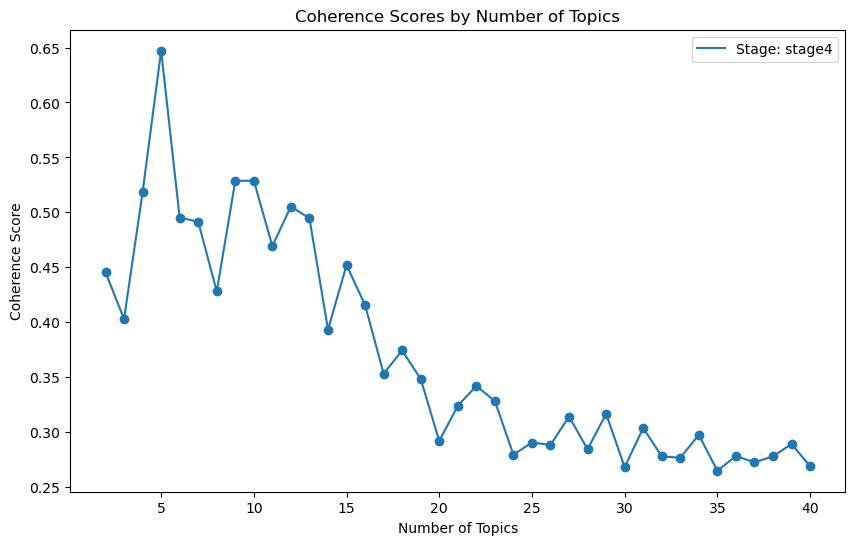

AttributeError: 'TopicModeling' object has no attribute 'plot_word_cloud'

In [912]:
topic_modeling.plot_coherence()
topic_modeling.plot_word_cloud(stage = 5, num_topics=18, num_words=10)

In [ ]:
#!rm -rf HSEPY/
#!git clone https://github.com/AlbertLeo1/HSEPY.git 
#data_processor.combined_df
#!pip install numpy --upgrade  # Or specify a version


<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Topic Modelling
</span>

In [ ]:
topic_modeling.plot_cloud('stage5', list(range(2, 21)))#specify the range of topics to explore from 2 to 21.

In [ ]:
topic_modeling.plot_cloud('stage5', [2, 6, 8, 16, 20])#splot specific topics combinations

#### <em>2. Using torch create and train neural network to predict target class (use train set to calculate loss and update weights. validation set to calculate f1 average score after every epoch and test set for final testing) Experiment with size of layers, number of layers, activation functions If you encounter OOM errors reduxe the number of layers/neurons.</em>

<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Train NN
</span>

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import KeyedVectors

class Vectorizer:
    def __init__(self, method='tfidf', ngram_range=(1, 2), max_features=4000, 
                 data_type='tokenized', embedding_file_paths=None):
        """
        Initializes the Vectorizer with specified parameters.

        Args:
            method (str): The vectorization method to use ('tfidf' or 'count').
            ngram_range (tuple): The range of n-grams to consider.
            max_features (int): The maximum number of features to extract.
            data_type (str): The type of data being processed ('tokenized' or 'embedding').
            embedding_file_paths (list or None): List of file paths for embedding files.
        """
        self.method = method
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vectorization = None
        self.data_type = data_type
        self.embedding_file_paths = embedding_file_paths if embedding_file_paths is not None else []

    def fit_transform(self, X_train, X_val, y_train=None, y_val=None):
        """
        Fit the vectorizer on the training data and transform both training and validation data.

        Args:
            X_train (list): Training data.
            X_val (list): Validation data.
            y_train (list or None): Target labels for training data (optional).
            y_val (list or None): Target labels for validation data (optional).

        Returns:
            tuple: Transformed training and validation data along with their labels if provided.
        """
        # Choose vectorization method
        if self.method == 'tfidf':
            self.vectorization = TfidfVectorizer(ngram_range=self.ngram_range, max_features=self.max_features)
        elif self.method == 'count':
            self.vectorization = CountVectorizer(ngram_range=self.ngram_range, max_features=self.max_features)
        else:
            raise ValueError("Unsupported method. Use 'tfidf' or 'count'.")

        # Fit on the training data
        X_train_vec = self.vectorization.fit_transform(X_train).toarray()
        X_val_vec = self.vectorization.transform(X_val).toarray()

        # Convert target labels to NumPy arrays if provided
        y_train_vec = np.array(y_train) if y_train is not None else None
        y_val_vec = np.array(y_val) if y_val is not None else None
        
        # Return transformed data based on data type
        if self.data_type == 'tokenized':
            return X_train_vec, X_val_vec, y_train_vec, y_val_vec
        else:
            print("Calling a wrong method for your data?")

    def transform(self, X):
        """
        Transform the test data using the fitted vectorizer.

        Args:
            X (list): Test data to be transformed.

        Returns:
            array: Transformed test data.
        """
        if self.data_type == 'tokenized':
            return self.vectorization.transform(X).toarray()
        else:
            print("Calling a wrong method for your data?")

    def load_embeddings(self):
        """
        Loads embeddings from one or more .bin files.

        Returns:
            tuple: Combined embedding matrix and word indices if data type is 'embedding'.
        """
        embedding_matrices = []
        word_indices = {}

        # Check if embedding_file_paths is a single string or a list
        if isinstance(self.embedding_file_paths, str):
            self.embedding_file_paths = [self.embedding_file_paths]

        for file_path in self.embedding_file_paths:
            # Load word embeddings from the specified file
            model = KeyedVectors.load_word2vec_format(file_path, binary=True)
            
            # Get the vocabulary size and embedding dimension
            vocab_size = len(model.key_to_index)
            embedding_dimension = model.vector_size
            embedding_matrix = np.zeros((vocab_size, embedding_dimension))

            # Create a word index mapping
            word_index = {word: i for i, word in enumerate(model.key_to_index)}
            for word, i in word_index.items():
                embedding_matrix[i] = model[word]

            # Append the current embedding matrix to the list
            embedding_matrices.append(embedding_matrix)

            # Update the global word index if necessary
            word_indices.update(word_index)

        # Concatenate all embedding matrices into one
        combined_embedding_matrix = np.vstack(embedding_matrices)

        # Return combined embeddings and word indices based on data type
        if self.data_type == 'embedding':
            return combined_embedding_matrix, word_indices
        else:
            print("Calling a wrong method for your data?")

    def texts_to_indices(self, texts, word_index):
        """
        Converts texts into lists of indices based on the provided word index.

        Args:
            texts (list): List of texts to convert.
            word_index (dict): Dictionary mapping words to indices.

        Returns:
            list: List of lists containing indices for each text.
        """
        indices_list = []
        for text in texts:
            # Convert each word in the text to its corresponding index
            indices = [word_index[word] for word in text.split() if word in word_index]
            indices_list.append(indices)

        # Return indices based on data type
        if self.data_type == 'embedding':
            return indices_list
        else:
            print("Calling a wrong method for your data?")

    def get_embedding_data(self, embedding_matrix, texts, word_index):
        """
        Returns embeddings for the given texts based on the provided embedding matrix.

        Args:
            embedding_matrix (array): Matrix containing word embeddings.
            texts (list): List of texts to get embeddings for.
            word_index (dict): Dictionary mapping words to indices.

        Returns:
            array: Array of embeddings for the input texts.
        """
        # Convert texts to indices
        indices_list = self.texts_to_indices(texts, word_index)
        
        # Initialize embeddings array
        embeddings = np.zeros((len(texts), embedding_matrix.shape[1]))

        for i, index_list in enumerate(indices_list):
            if index_list:
                # Calculate the mean embedding for the indices in the list
                embeddings[i] = np.mean(embedding_matrix[index_list], axis=0)

        # Return embeddings based on data type
        if self.data_type == 'embedding':
            return embeddings
        else:
            print("Calling a wrong method for your data?")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class CustomTextDataset(Dataset):
    """Custom dataset for handling text data."""
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx]) if self.y is not None else self.X[idx]


class MLPClassifier(nn.Module):
    """Multilayer Perceptron model for text classification.

    Args:
        stages (list): List of stages for processing.
        vectorizer: Vectorizer instance for text data.
        num_classes (int, optional): Number of output classes. Defaults to None.
        hidden_size (int or list, optional): Size of hidden layers. Defaults to 128.
        num_layers (int, optional): Number of hidden layers. Defaults to 2.
        activation_fn (str, optional): Activation function name. Defaults to 'relu'.
        learning_rate (float, optional): Learning rate for optimizer. Defaults to 0.00005.
        batch_size (int, optional): Batch size for training. Defaults to 32.
        patience (int, optional): Early stopping patience. Defaults to 10.
        num_epochs (int, optional): Number of epochs for training. Defaults to 50.
    """
    
    
    def __init__(self, stages, vectorizer, num_classes=None, hidden_size=[128, 64], num_layers=2, 
                 activation_fn='relu', learning_rate=0.00007, batch_size=64, 
                 patience=10, num_epochs=50):
        super(MLPClassifier, self).__init__()
        self.stages = stages  # Store the stages for processing
        self.vectorizer = vectorizer  # Assign the vectorizer for data transformation
        self.embedding_file_paths = vectorizer.embedding_file_paths  # Retrieve embedding file paths from vectorizer
        self.hidden_size = hidden_size if isinstance(hidden_size, list) else [hidden_size]  # Set hidden size as a list
        self.layer = []  # Initialize list to store layers
        self.best_f1_score = 0  # Initialize the best F1 score
        
        # Initialize a DataFrame to collect all epoch data across stages
        self.all_epoch_data = pd.DataFrame(columns=["Stage", "Epoch", "Loss", "F1_macro", "Prediction"])
    
        for stage in self.stages: 
            print(f"Processing Stage: {stage}")  # Print the current stage being processed
            tokenized_data = pipeline.get_tokenized_data(f'stage_{stage}')  # Retrieve tokenized data for the current stage
            self.X_train, self.X_val, self.y_train, self.y_val, self.test_data = tokenized_data  # Unpack tokenized data
            self.num_classes = num_classes  # Set number of classes
            
            # If num_classes is not provided, infer from training data
            if num_classes is None:
                self.num_classes = len(set(self.y_train))  # Calculate the number of unique classes from training labels
                
            self.batch_size = batch_size  # Set batch size for training
            
            # Calculate input size based on data type
            if self.vectorizer.data_type == 'embedding':
                self.input_size = self.prepare_embedding_data()  # Prepare input size for embedding data
                    
            elif self.vectorizer.data_type == 'tokenized':
                self.input_size = self.prepare_tokenized_data()  # Prepare input size for tokenized data
                
            else:
                print("Error: Unsupported data type. Please use 'embedding' or 'tokenized'.")  # Error message for unsupported data types
                raise ValueError("Unsupported data type: {}".format(self.vectorizer.data_type))
    
            self.class_weights = self.calculate_class_weights(self.y_train)  # Calculate class weights for handling class imbalance
            
            # Define the activation function based on user input
            self.activation_function = self.get_activation_function(activation_fn)
            
            # Define the MLP structure with dynamic input size and output layer based on num_classes
            self.network = self.build_network()
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device for computation
            self.network.to(self.device)  # Move the model to the specified device
            
            # Set the appropriate loss function based on number of classes
            if self.num_classes == 1:
                self.criterion = nn.BCEWithLogitsLoss()  # Use binary cross-entropy loss for binary classification
            else:
                self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)  # Use cross-entropy loss for multi-class classification
            
            # Layers and training components
            self.layers = list(self.network.children())  # Extract the layers from the network
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)  # Set up the Adam optimizer
            self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2)  # Learning rate scheduler
            
            # Set up training parameters
            self.patience = patience  # Set the patience for early stopping
            self.num_epochs = num_epochs  # Set total epochs for training
            self.epoch_data = pd.DataFrame(columns=["Epoch", "Loss", "F1_macro", "Prediction"])  # DataFrame to collect epoch data
            self.all_epoch_data = pd.concat([self.all_epoch_data, self.epoch_data], ignore_index=True)  # Concatenate epoch data across stages

    
    def prepare_tokenized_data(self):
        """Prepare data for both binary and multiclass classification using the vectorizer.
    
        This method transforms the training and validation datasets into tokenized formats 
        suitable for classification tasks. It also prepares data loaders for training, 
        validation, and optionally testing.
    
        Returns:
            int: The input size for building the network based on the vectorized dimension.
                  Returns None if an error occurs during preparation.
        
        Raises:
            ValueError: If vectorization results in None or if the data does not conform
                        to expected dimensions.
        """
        try:
            # Initialize y_train_vec and y_val_vec to None
            y_train_vec, y_val_vec = None, None
    
            # Assuming the vectorizer is handling tokenized data
            # Transform the data using the vectorizer
            X_train_vec, X_val_vec, y_train_vec, y_val_vec = self.vectorizer.fit_transform(self.X_train, self.X_val, self.y_train, self.y_val)
    
            # Check that vectorization results are valid
            if X_train_vec is None or X_val_vec is None:
                raise ValueError("Vectorization resulted in None for training or validation data.")
    
            # Ensure the resulting arrays are 2D
            if len(X_train_vec.shape) != 2 or len(X_val_vec.shape) != 2:
                raise ValueError("Vectorized data must be 2D arrays.")
    
            # Handle labels
            y_train_vec = np.ravel(y_train_vec) if y_train_vec is not None else np.ravel(self.y_train)
            y_val_vec = np.ravel(y_val_vec) if y_val_vec is not None else np.ravel(self.y_val)
    
            # Check unique classes for binary vs multiclass classification
            unique_classes = np.unique(self.y_train)
            if len(unique_classes) > 2:
                # Multiclass: one-hot encode labels
                lb = LabelBinarizer()
                y_train_vec = lb.fit_transform(y_train_vec)
                y_val_vec = lb.transform(y_val_vec)
    
            # Automatically set input size
            input_size = X_train_vec.shape[1]
            assert X_train_vec.shape[0] == len(y_train_vec), "Mismatch in X_train and y_train lengths"
            assert X_val_vec.shape[0] == len(y_val_vec), "Mismatch in X_val and y_val lengths"
    
            # Prepare data loaders for training and validation
            self.train_loader = DataLoader(CustomTextDataset(X_train_vec, y_train_vec), batch_size=self.batch_size, shuffle=True)
            self.val_loader = DataLoader(CustomTextDataset(X_val_vec, y_val_vec), batch_size=self.batch_size, shuffle=False)
    
            # Prepare test data if applicable
            if hasattr(self, 'test_data') and self.test_data is not None:
                self.test_data_vec = self.vectorizer.transform(self.test_data)
                self.test_loader = DataLoader(CustomTextDataset(self.test_data_vec), batch_size=self.batch_size, shuffle=False)
    
            return input_size  # Return the input size for building the network
    
        except Exception as e:
            print(f"An error occurred in prepare_tokenized_data: {str(e)}")
            return None  # Ensure a return value even on failure


    def prepare_embedding_data(self):
        """Prepare data for classification using only embeddings.
    
        This method loads embeddings from a specified file, processes training and validation
        datasets to obtain embedding vectors, and prepares data loaders for training,
        validation, and optionally testing.
    
        Returns:
            int: The input size for building the network based on the embedding dimension.
                  Returns None if an error occurs during preparation.
        
        Raises:
            ValueError: If the embedding file path is not specified or if the data does not
                        conform to expected dimensions.
        """
        try:
            # Load embeddings from the specified file
            if self.embedding_file_paths is not None:
                embedding_matrix, word_index = self.vectorizer.load_embeddings()
            else:
                raise ValueError("Embedding file path must be specified for embedding data type.")
    
            # Use the vectorizer to get the embeddings for X_train and X_val
            X_train_vec = self.vectorizer.get_embedding_data(embedding_matrix, self.X_train, word_index)
            X_val_vec = self.vectorizer.get_embedding_data(embedding_matrix, self.X_val, word_index)
    
            # Ensure embeddings are in 2D array format
            if len(X_train_vec.shape) != 2 or len(X_val_vec.shape) != 2:
                raise ValueError("Embedding data must be 2D arrays.")
    
            # Handle labels (assumed to be present as y_train, y_val)
            y_train_vec = np.ravel(self.y_train) if self.y_train is not None else None
            y_val_vec = np.ravel(self.y_val) if self.y_val is not None else None
    
            # Check unique classes for binary vs multiclass classification
            unique_classes = np.unique(y_train_vec)
            if len(unique_classes) > 2:
                # Multiclass: one-hot encode labels
                lb = LabelBinarizer()
                y_train_vec = lb.fit_transform(y_train_vec)
                y_val_vec = lb.transform(y_val_vec)
    
            # Automatically set input size
            input_size = X_train_vec.shape[1]  
            assert X_train_vec.shape[0] == len(y_train_vec), "Mismatch in X_train and y_train lengths"
            assert X_val_vec.shape[0] == len(y_val_vec), "Mismatch in X_val and y_val lengths"
    
            # Prepare data loaders for training and validation
            self.train_loader = DataLoader(CustomTextDataset(X_train_vec, y_train_vec), batch_size=self.batch_size, shuffle=True)
            self.val_loader = DataLoader(CustomTextDataset(X_val_vec, y_val_vec), batch_size=self.batch_size, shuffle=False)
    
            # Prepare test data if applicable
            if hasattr(self, 'test_data') and self.test_data is not None:
                self.test_data_vec = self.vectorizer.get_embedding_data(embedding_matrix, self.test_data, word_index)
                self.test_loader = DataLoader(CustomTextDataset(self.test_data_vec), batch_size=self.batch_size, shuffle=False)
    
            return input_size  # Return the input size for building the network
    
        except Exception as e:
            print(f"An error occurred in prepare_data: {str(e)}")
            return None  # Ensure a return value even on failure


    
    def forward(self, x):
        """Define the forward pass."""
        return self.network(x)

        
    def update_layer(self, index, new_layer, new_learning_rate=None, new_batch_size=None, new_num_epochs=None):
        """Update a layer in the network at the specified index and modify learning parameters.
    
        Args:
            index (int): The index of the layer to update.
            new_layer (nn.Module): The new layer to replace the existing layer at the specified index.
            new_learning_rate (float, optional): New learning rate for the optimizer. If not provided, the current learning rate is retained.
            new_batch_size (int, optional): New batch size for training. If not provided, the current batch size is retained.
            new_num_epochs (int, optional): New number of epochs for training. If not provided, the current number of epochs is retained.
    
        Raises:
            IndexError: If the specified index is out of range for the current layers.
        """
        layers = list(self.network.children())  # Get the current layers
        # Check if the index is valid
        if index < -len(layers) or index >= len(layers):
            raise IndexError("Layer index out of range.")  
        
        layers[index] = new_layer  # Replace the specified layer
        self.network = nn.Sequential(*layers)  # Rebuild the network with the modified layers
        
        # Update learning parameters if provided
        if new_learning_rate is not None:
            self.learning_rate = new_learning_rate  # Update learning rate
        if new_batch_size is not None:
            self.batch_size = new_batch_size  # Update batch size
        if new_num_epochs is not None:
            self.num_epochs = new_num_epochs  # Update number of epochs
    
        # Update the optimizer with the new learning rate
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)
    
        # Print confirmation of the updates
        print(f"Layer at index {index} updated. Learning rate: {self.learning_rate}, Batch size: {self.batch_size}, Epochs: {self.num_epochs}")

    
    def calculate_class_weights(self, y_train):
        """Calculate class weights based on the training targets."""
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        return torch.FloatTensor(class_weights)  # Ensure class weights are on the correct device

    def get_activation_function(self, activation_fn):
        """Return the activation function based on the name provided."""
        if activation_fn == 'relu':
            return nn.ReLU()
        elif activation_fn == 'sigmoid':
            return nn.Sigmoid()
        elif activation_fn == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")
            
    def build_network(self):
        """Build the neural network architecture based on the specified hidden layers and output configuration.
    
        This method constructs the network by sequentially adding layers. 
        It creates hidden layers as defined in self.hidden_size and adds an output layer 
        based on the number of classes specified for the task (binary or multi-class classification).
    
        Returns:
            nn.Sequential: A PyTorch sequential model containing the configured layers.
        """
        layers = []  # List to hold all the layers of the network
        input_size = self.input_size  # Start with the input size defined for the model
    
        # Build hidden layers based on specified hidden sizes
        for h in self.hidden_size:
            layers.append(nn.Linear(input_size, h))  # Add a linear layer
            layers.append(self.activation_function)  # Add the activation function
            input_size = h  # Update input size for the next layer
    
        # Build the output layer
        if self.num_classes == 1:  # For binary classification
            layers.append(nn.Linear(input_size, 1))  # Single output neuron
            layers.append(nn.Sigmoid())  # Sigmoid activation function for binary output
        else:  # For multi-class classification
            layers.append(nn.Linear(input_size, self.num_classes))  # Linear layer for multi-class outputs
            # Softmax is typically used for multi-class output, but it can also be incorporated in the loss function.
    
        return nn.Sequential(*layers)  # Return the sequential model containing all layers

    
    def train(self):
        """Train the model with Out Of Memory (OOM) error handling.
    
        This method iteratively trains the neural network for a specified number of epochs, 
        monitors training and validation losses, and evaluates the F1 score. It also implements 
        early stopping based on validation F1 score and handles potential OOM errors by reducing 
        model complexity.
    
        Returns:
            pd.DataFrame: A DataFrame containing the epoch data including loss, F1 score, and predictions.
        """
        best_f1 = 0.0  # Initialize best F1 score
        epochs_without_improvement = 0  # Counter for early stopping
        train_losses = []  # List to store training losses
        val_losses = []  # List to store validation losses
        
        # Loop over the specified number of epochs
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}")
            self.network.train()  # Set the model to training mode
            all_train_preds = []  # List to store predictions from training
            running_loss = 0.0  # Variable to accumulate training loss
    
            try:
                # Iterate over batches from the training loader
                for texts, labels in self.train_loader:
                    self.optimizer.zero_grad()  # Clear previous gradients
                    outputs = self.network(texts)  # Forward pass through the network
    
                    # Handle loss calculation based on the number of classes
                    if self.num_classes == 1:
                        labels = labels.view(-1, 1)  # Reshape labels for binary classification
                        loss = self.criterion(outputs, labels)  # Compute binary loss
                    else:
                        loss = self.criterion(outputs, labels)  # Compute multi-class loss
                    
                    loss.backward()  # Backward pass to compute gradients
                    self.optimizer.step()  # Update model parameters
    
                    running_loss += loss.item()  # Accumulate loss for the current batch
    
                    # Generate predictions based on model output
                    if self.num_classes == 1:
                        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert outputs to binary predictions
                    else:
                        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes for multi-class
    
                    all_train_preds.extend(predicted.cpu().numpy())  # Store predictions
    
                # Calculate average training loss for the epoch
                train_loss = running_loss / len(self.train_loader)
                train_losses.append(train_loss)  # Append to training losses
    
                # Validate the model and retrieve validation outputs and loss
                val_outputs, val_labels, average_loss = self.validate()
                val_losses.append(average_loss)  # Append validation loss
    
                # Evaluate F1 score on the validation set
                f1 = self.evaluate(val_labels, val_outputs)
    
                # Create a DataFrame for the current epoch's data
                new_epoch_data = pd.DataFrame({
                    "Epoch": [epoch + 1], 
                    "Loss": train_loss,
                    "F1_macro": [f1],
                    "Prediction": [val_outputs],
                })
    
                self.epoch_data = pd.concat([self.epoch_data, new_epoch_data], ignore_index=True)
    
                # Print the results for the current epoch
                print(f'Epoch [{epoch + 1}], F1 Score: {f1:.4f}, Validation Loss: {average_loss:.4f}')
    
                # Plot the confusion matrix after each epoch
                self.plot_confusion_matrix(val_labels, val_outputs)
    
                # Call the learning rate scheduler to adjust learning rate
                self.scheduler.step(average_loss)
                print(f'Current learning rate: {self.scheduler.optimizer.param_groups[0]["lr"]}')
    
                # Early stopping logic based on F1 score improvement
                if f1 > best_f1:
                    best_f1 = f1  # Update best F1 score
                    epochs_without_improvement = 0  # Reset counter
                else:
                    epochs_without_improvement += 1  # Increment counter for no improvement
                    if epochs_without_improvement >= self.patience: 
                        display(Markdown(f"<pre style='color: Red; font-size: 20'>Early stopping triggered after {epoch + 1} epochs.</pre>"))
                        break  # Stop training if patience is exceeded
    
            except RuntimeError as e:
                # Handle out of memory (OOM) error by reducing model complexity
                if 'out of memory' in str(e):
                    print("Encountered OOM error. Reducing the number of layers or neurons.")
                    self.hidden_size = [max(32, layer // 2) for layer in self.hidden_size]  # Reduce the size of hidden layers
                    self.network = self.build_network()  # Rebuild the model with new size
                    self.network.to(self.device)  # Ensure the model is on the correct device
                    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)  # Reinitialize optimizer
                    print("Retrying training with a smaller model.")
                    break  # Exit the loop and retry training
    
        # After training, plot the losses
        self.plot_loss(train_losses, val_losses)
    
        return self.epoch_data  # Return accumulated data for all epochs



    def evaluate(self, true_labels, predicted_labels):
        """Evaluate the model using F1 score.
    
        This method calculates the F1 score based on the true labels and predicted labels. 
        It also updates the best F1 score if the current score exceeds the previously recorded best.
    
        Args:
            true_labels (list or numpy array): The true labels for the data being evaluated.
            predicted_labels (list or numpy array): The predicted labels from the model.
    
        Returns:
            float: The calculated F1 score.
        """
        # If using single output for binary classification, convert predicted_labels to binary
        if self.num_classes == 1:
            predicted_labels = (predicted_labels > 0.5).astype(int)  # Convert probabilities to binary labels
    
        # Calculate the F1 score with macro averaging
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        
        # Update best F1 score if the current F1 score is higher
        if f1 > self.best_f1_score:
            self.best_f1_score = f1  # Store the best F1 score
    
        return f1  # Return the calculated F1 score



    def validate(self):
        """Validate the model and return predictions and true labels.
    
        This method evaluates the model's performance on the validation set and computes 
        the average loss. It returns the predictions made by the model and the true labels 
        for comparison.
    
        Returns:
            tuple: A tuple containing:
                - list: Predicted labels for the validation set.
                - list: True labels for the validation set.
                - float: Average loss over the validation set.
        """
        self.network.eval()  # Set the model to evaluation mode
        val_outputs = []  # Initialize a list to store validation predictions
        val_labels = []   # Initialize a list to store true labels
        total_loss = 0.0  # Initialize total loss accumulator
        
        with torch.no_grad():  # Disable gradient calculations for efficiency
            for val_texts, val_labels_batch in self.val_loader:
                outputs = self.network(val_texts)  # Perform forward pass on validation data
                loss = self.criterion(outputs, val_labels_batch)  # Calculate the loss
                total_loss += loss.item()  # Accumulate total loss
                
                # Process outputs based on the number of classes
                if self.num_classes == 1:
                    # Convert outputs to binary predictions for binary classification
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                else:
                    # For multi-class classification, get the index of the max output
                    predicted = torch.argmax(outputs, axis=1)
        
                # Store predictions and true labels
                val_outputs.extend(predicted.cpu().numpy())
                val_labels.extend(val_labels_batch.cpu().numpy())
        
        # Calculate the average loss over all validation batches
        average_loss = total_loss / len(self.val_loader)
        
        return val_outputs, val_labels, average_loss  # Return predictions, true labels, and average loss



    def test(self):
        """Test the model on the test set and display the final F1 score if labels are available.
    
        This method evaluates the model's performance on unseen data and computes the F1 score.
        If true labels for the test set are not available, it will notify the user.
        
        Returns:
            list: A list of predicted labels for the test set.
        """
        self.network.eval()  # Set the model to evaluation mode
        test_preds = []  # Initialize a list to store test predictions
        
        with torch.no_grad():  # Disable gradient calculations for efficiency
            for texts in self.test_loader:
                outputs = self.network(texts)  # Perform forward pass on test data
                
                # Process outputs based on the number of classes
                if self.num_classes == 1:
                    # Convert outputs to binary predictions for binary classification
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    test_preds.extend(predicted.cpu().numpy())  # Store predictions
                else:
                    # For multi-class classification, get the index of the max output
                    _, predicted = torch.max(outputs.data, 1)
                    test_preds.extend(predicted.cpu().numpy())  # Store predictions
        
        # Check if test labels are available
        if hasattr(self, 'y_test'):
            test_labels = self.y_test.tolist()  # Use actual test labels if available
            
            # Calculate the F1 score using the true labels and predictions
            final_f1 = f1_score(test_labels, test_preds, average='macro')
            # Display the final F1 score in Markdown format
            display(Markdown(f"<pre style='color: Chartreuse; font-size: 20'>Final F1 Score: {final_f1:.4f}</pre>"))
        else:
            # If no true labels are available, notify the user and skip F1 score calculation
            display(Markdown(f"<pre style='color: Chartreuse; font-size: 20'>Final F1 Score: No true label</pre>"))
        
        return test_preds  # Return the list of predicted labels



    def plot_loss(self, train_losses, val_losses):
        """Plot the training and validation loss."""
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, true_labels, predicted_labels):
        """Plot the confusion matrix."""
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(1.5, 0.6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def wrong_prediction_at_best_epoch(self, X_val):
        """Get all wrong predictions from the best F1 score epoch and drop duplicates based on val_text."""
        # Find the index of the epoch with the best F1 score
        best_epoch_index = self.epoch_data['F1_macro'].idxmax()
        best_epoch_predictions = self.epoch_data.loc[best_epoch_index, 'Prediction']
        
        # Create a DataFrame to hold wrong predictions
        best_epoch_wrong_df = pd.DataFrame({
            "prediction": best_epoch_predictions,
            "actual": self.y_val.tolist(),  # Use validation true labels
            "val_text": X_val.tolist()       # Use validation texts
        })
        
        # Check for length mismatch
        if len(best_epoch_predictions) != len(self.y_val) or len(best_epoch_predictions) != len(X_val):
            print(f"Warning: Length mismatch at best epoch {best_epoch_index + 1}. "
                  f"Predictions: {len(best_epoch_predictions)}, Actual: {len(self.y_val)}, Text: {len(X_val)}.")
        
        # Filter for wrong predictions
        wrong_predictions_df = best_epoch_wrong_df[best_epoch_wrong_df['prediction'] != best_epoch_wrong_df['actual']]
        
        # Drop duplicates based on the 'val_text' column
        wrong_predictions_df = wrong_predictions_df.drop_duplicates(subset='val_text')
        
        return wrong_predictions_df


vectorizer=Vectorizer(ngram_range=(1, 2), max_features=4000)
classifier = MLPClassifier(stages=[3], vectorizer=vectorizer, hidden_size=[128, 64], learning_rate=0.00008)
classifier.train()
display(Markdown(f"<pre style='color: Chartreuse; font-size: 20'>Best F1 Score: {classifier.best_f1_score:.4f}</pre>"))

In [ ]:
# Test the model
test_predictions = pd.DataFrame({'prediction': classifier.test(), 'true_label': None})
test_predictions

In [ ]:
Counter(test_predictions['prediction'])

In [ ]:
_, X_val_raw, _, _, _ = pipeline.get_tokenized_data('stage_0')
# Get predictions from the classifier
wrong_predictions = classifier.wrong_prediction_at_best_epoch(X_val=X_val_raw)
wrong_predictions

In [ ]:
wrong_preds_class = wrong_predictions.groupby('prediction').size()

# Plot
plt.figure(figsize=(5, 3))
wrong_preds_class.plot(kind='bar')
plt.title('Count of Wrong Predictions per Class')
plt.xlabel('Prediction Class (0 or 1)')
plt.ylabel('Count of Wrong Predictions')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#### 3. Create embeddings using this dataset: At the end of every epoch, print dot product similarity between embeddings for different pairs of words to see if they change in direction we would like (for opposite words it should gradually become negative, for similar - positive, for not related words - close to 0):

<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Word Embedding
</span>

In [ ]:
from nltk.corpus import wordnet as wn
import spacy

class WordRelationships:
    def __init__(self, vocab, nlp):
        """Initialize WordRelationships with a vocabulary and a SpaCy NLP model.
        
        Args:
            vocab (list): List of words in the vocabulary.
            nlp: SpaCy NLP model instance for processing text.
        """
        self.vocab = vocab
        self.nlp = nlp  # Store the nlp instance

        # Precompute SpaCy tokens for efficiency
        self.vocab_tokens = {word: self.nlp(word) for word in self.vocab}
        
        # Build relationships if vocabulary is not empty
        self.antonyms, self.synonyms, self.unrelated = (self.build_word_relationships() 
                                                        if self.vocab else ({}, {}, {}))

    def build_word_relationships(self):
        """Build dictionaries of antonyms, synonyms, and unrelated words."""
        antonym_dict = {}
        synonym_dict = {}
        unrelated_dict = {}

        for word in self.vocab:
            antonyms, synonyms = self.get_wordnet_relationships(word)
            if antonyms:
                antonym_dict[word] = antonyms
            if synonyms:
                synonym_dict[word] = synonyms
            
            unrelated = self.get_unrelated_words(word)
            if unrelated:
                unrelated_dict[word] = unrelated

        return antonym_dict, synonym_dict, unrelated_dict

    def get_wordnet_relationships(self, word):
        """Get synonyms and antonyms from WordNet for a given word.

        Args:
            word (str): The word to find relationships for.

        Returns:
            tuple: A tuple containing lists of antonyms and synonyms.
        """
        antonyms, synonyms = set(), set()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.add(lemma.antonyms()[0].name())
                synonyms.add(lemma.name())
        return list(antonyms), list(synonyms)  # Return as lists

    def get_unrelated_words(self, word, topn=10, threshold=0.1):
        """Get words that are unrelated based on low similarity.

        Args:
            word (str): The word to find unrelated words for.
            topn (int): Maximum number of unrelated words to return.
            threshold (float): Similarity threshold to determine unrelatedness.

        Returns:
            list: A list of unrelated words.
        """
        word_token = self.vocab_tokens[word]
        unrelated_words = []

        # Check similarity for all words and filter based on threshold
        for vocab_word, vocab_token in self.vocab_tokens.items():
            similarity = word_token.similarity(vocab_token)
            if 0 < similarity < threshold:
                unrelated_words.append(vocab_word)
                if len(unrelated_words) == topn:
                    break
        return unrelated_words

    def get_opposite_words(self, word):
        """Return a list of antonym words for the given word."""
        return self.antonyms.get(word, [])

    def get_synonyms(self, word):
        """Return a list of synonym words for the given word."""
        return self.synonyms.get(word, [])

    def get_relationship(self, word1, word2):
        """Identify the relationship between two words: synonym, opposite, unrelated, or related.

        Args:
            word1 (str): The first word.
            word2 (str): The second word.

        Returns:
            str: The relationship type between the two words.
        """
        synonyms_of_word1 = self.get_synonyms(word1)
        antonyms_of_word1 = self.get_opposite_words(word1)
        
        if word2 in synonyms_of_word1:
            return "synonym"
        elif word2 in antonyms_of_word1:
            return "opposite"
        elif word2 in self.unrelated.get(word1, []):
            return "unrelated"
        else:
            return "related"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import spacy
from gensim.models import KeyedVectors

class EmbeddingDataset(Dataset):
    def __init__(self, word_pairs):
        self.word_pairs = word_pairs

    def __len__(self):
        return len(self.word_pairs)

    def __getitem__(self, idx):
        word1, word2, similarity = self.word_pairs[idx]
        return (torch.tensor(word1, dtype=torch.long), 
                torch.tensor(word2, dtype=torch.long), 
                torch.tensor(similarity, dtype=torch.float))


class WordEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(WordEmbeddingModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input):
        return self.embeddings(input)


class EmbeddingTrainer:
    """
    A class to train word embeddings based on tokenized data.

    Attributes:
        tokenized_data (pd.Series): The input tokenized data containing words.
        vocab (dict): A dictionary mapping words to unique indices.
        inv_vocab (dict): A dictionary mapping indices to words.
        vocab_size (int): The size of the vocabulary.
        epochs (int): The number of training epochs.
        nlp (spacy.Language): The spaCy model for word relationships.
        word_relationships (WordRelationships): An instance for managing word relationships.
        word_pairs (list): A list of word pairs generated from the tokenized data.
        dataset (EmbeddingDataset): An instance of the dataset containing word pairs.
        data_loader (DataLoader): A PyTorch DataLoader for batching the dataset.
        model (WordEmbeddingModel): The neural network model for word embeddings.
        optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
        criterion (nn.Module): The loss function used for training.
        word_vectors (KeyedVectors): A Gensim KeyedVectors instance for storing embeddings.
        symmetric (str): Defines behavior for handling symmetric word pairs ('keep' or 'drop').
        relationships_df (pd.DataFrame): A DataFrame to store similarity relationships for word pairs.
    """

    def __init__(self, tokenized_data: pd.Series, embedding_dim=100, batch_size=32, epochs=20, learning_rate=0.01, window_size=2, topn=10, symmetric='keep'):
        self.tokenized_data = tokenized_data
        self.vocab, self.inv_vocab = self.build_vocabulary(tokenized_data)  # Build vocabulary from tokenized data
        self.vocab_size = len(self.vocab)  # Calculate vocabulary size here
        self.epochs = epochs
        self.nlp = spacy.load("en_core_web_md")  # Load the spaCy model for word relationships

        # Pass the nlp instance to WordRelationships
        self.word_relationships = WordRelationships(self.vocab, self.nlp)  # Create an instance to handle word relationships
        self.word_pairs = self.generate_word_pairs(window_size, topn)  # Generate word pairs based on the context
        self.dataset = EmbeddingDataset(self.word_pairs)  # Create a dataset instance for word pairs
        self.data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)  # Create a DataLoader for batching
        self.model = WordEmbeddingModel(self.vocab_size, embedding_dim)  # Initialize the word embedding model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)  # Define the optimizer
        self.criterion = nn.CosineEmbeddingLoss()  # Define the loss function
        self.word_vectors = KeyedVectors(vector_size=embedding_dim)  # Initialize KeyedVectors for storing embeddings
        self.symmetric = symmetric  # Store the symmetry behavior choice
        
        # Create a DataFrame to store relationships between word pairs
        self.relationships_df = pd.DataFrame(index=[f"{self.inv_vocab[word1_idx]}<-->{self.inv_vocab[word2_idx]}" 
                                                    for word1_idx, word2_idx, _ in self.word_pairs])

    def generate_word_pairs(self, window_size=2, topn=10):
        """
        Generates word pairs from the tokenized data within a specified context window.
    
        Each word in the tokenized data is paired with its surrounding context words,
        with the option to filter out pairs based on the similarity relationships.
    
        Parameters:
            window_size (int): The size of the context window to look around each word.
            topn (int): The number of top context words to consider for each target word (not used in this implementation).
    
        Returns:
            list: A list of tuples, where each tuple contains the index of a target word,
                  the index of a context word, and a similarity flag (1 for opposite words, 0 otherwise).
        """
        word_pairs = []  # Initialize a list to store word pairs
        for document in self.tokenized_data:  # Iterate over each document in the tokenized data
            words = document.split()  # Split the document into individual words
            for i, word in enumerate(words):  # Enumerate through the words to get their indices
                # Define the start and end indices for the context window
                start = max(0, i - window_size)  # Ensure start index is not negative
                end = min(len(words), i + window_size + 1)  # Ensure end index does not exceed the word list
                # Extract context words from the current window, excluding the target word itself
                context_words = [words[j] for j in range(start, end) if j != i]
                for context_word in context_words:  # Iterate through the context words
                    # Check if both the target and context words are in the vocabulary
                    if word in self.vocab and context_word in self.vocab:
                        # Set similarity flag: 1 if the word has no opposite words, else 0
                        similarity = 1 if self.word_relationships.get_opposite_words(word) == [] else 0
                        # Append the target word index, context word index, and similarity to the word_pairs list
                        word_pairs.append((self.vocab[word], self.vocab[context_word], similarity))
        return word_pairs  # Return the list of generated word pairs


    def train(self):
        """
        Trains the word embedding model for a specified number of epochs.
    
        This method performs the forward and backward passes through the model, 
        computes the loss using cosine embedding loss, and updates the model weights 
        using the Adam optimizer. It also tracks the average loss for each epoch 
        and updates the relationships DataFrame after training.
    
        Returns:
            None
        """
        self.model.train()  # Set the model to training mode
        
        for epoch in range(self.epochs):  # Iterate over each epoch
            total_loss = 0  # Reset total loss at the start of each epoch
            
            for word1, word2, similarity in self.data_loader:  # Iterate through batches from the data loader
                # Check if any index is out of range
                if word1.max() >= self.vocab_size or word2.max() >= self.vocab_size:  # Ensure indices are within vocabulary size
                    print("Index out of range!")  # Print warning if index is out of range
                    continue  # Skip this batch if indices are out of range
    
                self.optimizer.zero_grad()  # Clear previous gradients
                
                # Forward pass for word1 and word2 to get their embeddings
                emb1 = self.model(word1)  # Get embeddings for the first word
                emb2 = self.model(word2)  # Get embeddings for the second word
    
                # Compute loss using cosine embedding loss
                loss = self.criterion(emb1, emb2, similarity)  # Calculate the loss
                loss.backward()  # Perform the backward pass
                
                self.optimizer.step()  # Update model weights
                
                total_loss += loss.item()  # Accumulate the total loss
    
            # Calculate and print average loss for the epoch
            average_loss = total_loss / len(self.data_loader)  # Compute average loss
            display(Markdown(f"<strong style='color: Chartreuse; font-size: 20'>\nEpoch [{epoch + 1}/{self.epochs}], Loss: {average_loss:.4f}</strong>")) 
    
            # Update relationships DataFrame for each pair after training
            self.update_relationships(epoch)  # Update relationships based on training results
    
            self.evaluate_embeddings()  # Call the evaluation function to assess embeddings


    def update_relationships(self, epoch):
        """
        Updates the relationships DataFrame with similarity values for word pairs 
        after training.
    
        This method computes the cosine similarity between embeddings of word pairs 
        generated during training. It adds the similarity values to a new column 
        corresponding to the current epoch in the relationships DataFrame.
    
        Args:
            epoch (int): The current epoch number, used to create a unique column 
                         for the similarity values in the DataFrame.
    
        Returns:
            None
        """
        epoch_column = f"Epoch {epoch + 1}"  # Create a unique column name for the current epoch
    
        # Create a new column for the current epoch in the relationships DataFrame
        self.relationships_df[epoch_column] = None
    
        # Iterate through the generated word pairs
        for word1_idx, word2_idx, _ in self.word_pairs:
            # Check if both word indices exist in the inverse vocabulary
            if word1_idx in self.inv_vocab and word2_idx in self.inv_vocab:
                word1 = self.inv_vocab[word1_idx]  # Get the first word from the inverse vocabulary
                word2 = self.inv_vocab[word2_idx]  # Get the second word from the inverse vocabulary
                pair_label = f"{word1}<-->{word2}"  # Create a label for the word pair
                
                # Get embeddings for the word pair
                emb1 = self.model(torch.tensor(word1_idx, dtype=torch.long).unsqueeze(0))  # Get embedding for word1
                emb2 = self.model(torch.tensor(word2_idx, dtype=torch.long).unsqueeze(0))  # Get embedding for word2
    
                # Check if embeddings are non-zero
                if torch.count_nonzero(emb1) > 0 and torch.count_nonzero(emb2) > 0:
                    # Calculate the cosine similarity between the two embeddings
                    similarity = torch.dot(emb1.view(-1), emb2.view(-1)).item()
                    
                    # Store the similarity value in the corresponding epoch column
                    self.relationships_df.loc[pair_label, epoch_column] = similarity
                    self.relationships_df.index.name = "WordPair"  # Set the index name for the DataFrame


    def evaluate_embeddings(self):
        """
        Evaluates the learned embeddings by checking the similarity for word pairs.
    
        This method calculates the cosine similarity between the embeddings of word 
        pairs. It tracks evaluated pairs to avoid duplicate calculations, and it can 
        handle symmetry based on the class's `symmetric` attribute.
    
        If `symmetric` is set to 'drop', only unique pairs (word1, word2) are evaluated.
        If set to 'keep', both (word1, word2) and (word2, word1) pairs are evaluated.
    
        Returns:
            None
        """
        seen_pairs = set()  # To track already evaluated pairs
    
        # Iterate through the generated word pairs
        for word1_idx, word2_idx, _ in self.word_pairs:
            if self.symmetric == 'drop':
                # Only calculate similarity for unique pairs (word1, word2)
                if (word2_idx, word1_idx) in seen_pairs:
                    continue  # Skip already evaluated pairs
                seen_pairs.add((word1_idx, word2_idx))  # Track this pair as seen
    
            # Check if both word indices exist in the inverse vocabulary
            if word1_idx in self.inv_vocab and word2_idx in self.inv_vocab:
                word1 = self.inv_vocab[word1_idx]  # Get the first word from the inverse vocabulary
                word2 = self.inv_vocab[word2_idx]  # Get the second word from the inverse vocabulary
                
                # Get embeddings for the word pair
                emb1 = self.model(torch.tensor(word1_idx, dtype=torch.long).unsqueeze(0))  # Embedding for word1
                emb2 = self.model(torch.tensor(word2_idx, dtype=torch.long).unsqueeze(0))  # Embedding for word2
    
                # Check if embeddings are non-zero
                if torch.count_nonzero(emb1) > 0 and torch.count_nonzero(emb2) > 0:
                    # Calculate the cosine similarity between the two embeddings
                    similarity = torch.dot(emb1.view(-1), emb2.view(-1)).item()
    
                    # Get the relationship category (synonym, opposite, unrelated, related)
                    category = self.word_relationships.get_relationship(word1, word2)
    
                    # Print similarity for the pair
                    print(f'{word1} and {word2}: {similarity:.4f}')  # Uncomment to show the category: ({category})
    
                if self.symmetric == 'keep':
                    # If keeping symmetry, calculate the reverse as well
                    emb1, emb2 = emb2, emb1  # Swap embeddings
                    similarity = torch.dot(emb1.view(-1), emb2.view(-1)).item()  # Recalculate similarity
                    print(f'{self.inv_vocab[word2_idx]}<-->{self.inv_vocab[word1_idx]}: {similarity:.4f}')  # Print reversed pair similarity


    @staticmethod
    def build_vocabulary(tokenized_data):
        """
        Builds a vocabulary from the tokenized data.
    
        This method creates two dictionaries: 
        - `vocab`: mapping of words to unique indices.
        - `inv_vocab`: mapping of indices back to words.
    
        Args:
            tokenized_data (pd.Series): A series containing tokenized documents.
    
        Returns:
            tuple: A tuple containing:
                - vocab (dict): A dictionary mapping words to indices.
                - inv_vocab (dict): A dictionary mapping indices back to words.
        """
        vocab = {}  # Dictionary to hold the vocabulary mapping
        index = 0   # Initialize index for unique word assignment
    
        # Iterate through each document in the tokenized data
        for document in tokenized_data:
            # Split document into words
            for word in document.split():
                # If the word is not already in the vocabulary, add it
                if word not in vocab:
                    vocab[word] = index  # Map word to the current index
                    index += 1  # Increment the index for the next unique word
                
        # Create an inverse vocabulary mapping
        inv_vocab = {index: word for word, index in vocab.items()}
        return vocab, inv_vocab  # Return the vocabulary and its inverse
    

    def save_embeddings(self, filename='custom_embeddings.bin'):
        """
        Save the learned embeddings to a .bin file using Gensim's KeyedVectors format.
    
        This method retrieves the learned embeddings from the model and saves them
        in a binary format compatible with Gensim. It ensures that the vocabulary size
        matches the number of embedding vectors before saving.
    
        Args:
            filename (str): The name of the file to save embeddings to. Defaults to 'custom_embeddings.bin'.
    
        Returns:
            None
        """
        
        # Retrieve the learned embeddings as a NumPy array
        embeddings = self.model.embeddings.weight.data.numpy()
        
        # Ensure the vocab size matches the number of embedding vectors
        if len(self.inv_vocab) != embeddings.shape[0]:
            print("Error: Vocab size and embedding size do not match.")
            return  # Exit if there is a mismatch
        
        # Initialize KeyedVectors with preallocated vocab size and embedding dimensions
        vector_size = embeddings.shape[1]
        keyed_vectors = KeyedVectors(vector_size=vector_size)
        
        # Collect all words and their vectors in a list
        words = list(self.inv_vocab.values())
        
        # Use add_vectors to add all vectors in one batch
        keyed_vectors.add_vectors(words, embeddings)
        
        # Save in a binary Word2Vec format
        keyed_vectors.save_word2vec_format(filename, binary=True)
        print(f"Embeddings successfully saved to {filename}")  # Confirmation message
    

# Retrieve tokenized data for training and validation from stage_5
X_train, X_val, _, _, _ = pipeline.get_tokenized_data('stage_5')

# Combine training and validation data, and select the first 10 entries for demonstration
tokenized_data = pd.concat([X_train, X_val], ignore_index=True).head(10)

# Initialize the EmbeddingTrainer with the tokenized data
# 'symmetric' parameter is set to 'drop' to avoid calculating symmetry for word pairs
trainer = EmbeddingTrainer(tokenized_data, symmetric='drop')

# Train the embedding model using the initialized trainer
trainer.train()

# Save the learned embeddings to a binary file
trainer.save_embeddings('custom_embeddings.bin')

# Generate word pairs from the tokenized data
word_pairs = trainer.generate_word_pairs()

# Convert the word pairs (list of tuples) into a Pandas DataFrame
word_pairs_df = pd.DataFrame(word_pairs, columns=['Word1', 'Word2', 'Similarity'])

# Save the DataFrame containing word pairs to a CSV file
word_pairs_df.to_csv('word_pairs.csv', index=False)


In [ ]:
# To display the DataFrame of relationships
display(trainer.relationships_df)

#### 4. Use embeddings learned during previous task for classification with any sklearn model. Try to use google pretrained embeddings as well: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300.

<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Evaluation with Trained Embedding
</span>

In [ ]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown

class EmbeddingModel:
    def __init__(self, pipeline, stage_indices, custom_embeddings_path, additional_embeddings_path=None):
        """
        Initializes the EmbeddingModel.

        Args:
            pipeline: The data processing pipeline used to retrieve tokenized data.
            stage_indices (list): List of integers representing the stages to process.
            custom_embeddings_path (str): Path to the custom embeddings file.
            additional_embeddings_path (str, optional): Path to additional embeddings file. Default is None.
        """
        self.pipeline = pipeline
        self.stages = [f'stage_{i}' for i in stage_indices]  # Format stages from integers
        self.custom_embeddings_path = custom_embeddings_path
        self.additional_embeddings_path = additional_embeddings_path
        self.custom_embeddings = None
        self.additional_embeddings = None
        self.combined_embeddings = None

    def load_embeddings(self, file_path):
        """Load embeddings using Gensim from a binary file.

        Args:
            file_path (str): Path to the embeddings file.

        Returns:
            KeyedVectors: Loaded embeddings if successful, None otherwise.
        """
        try:
            return KeyedVectors.load_word2vec_format(file_path, binary=True)
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None

    def load_all_embeddings(self):
        """Load custom and optional additional embeddings."""
        print("Loading custom embeddings...")
        self.custom_embeddings = self.load_embeddings(self.custom_embeddings_path)

        if self.additional_embeddings_path is not None:  # Only load additional embeddings if a path is provided
            print("Loading additional embeddings...")
            self.additional_embeddings = self.load_embeddings(self.additional_embeddings_path)

        # Check if loading was successful
        if self.custom_embeddings is not None:
            print(f"Custom embeddings loaded. Number of words: {len(self.custom_embeddings)}")
        else:
            print("Failed to load custom embeddings.")

        if self.additional_embeddings is not None:
            print(f"Additional embeddings loaded. Number of words: {len(self.additional_embeddings)}")
        else:
            print("Failed to load additional embeddings.")

    def create_combined_embeddings(self):
        """Create a combined embedding dictionary by concatenating vectors from both."""
        if self.custom_embeddings is None:
            print("Custom embeddings must be loaded before creating combined embeddings.")
            return

        combined_embeddings = {}
        for word in self.custom_embeddings.index_to_key:  # Access words in custom embeddings
            combined_vector = self.custom_embeddings[word]  # Start with custom embeddings
            if self.additional_embeddings is not None and word in self.additional_embeddings:  # Check for additional embeddings
                # Concatenate vectors from both embeddings
                combined_vector = np.concatenate((combined_vector, self.additional_embeddings[word]))
            combined_embeddings[word] = combined_vector
            
        self.combined_embeddings = combined_embeddings

    def prepare_data(self, stage):
        """Load embeddings, create combined embeddings, and prepare data for a specific stage.

        Args:
            stage (str): The stage to prepare data for.

        Returns:
            tuple: (X_train_embeddings, X_val_embeddings, y_train, y_val) or (None, None, None, None) on failure.
        """
        self.load_all_embeddings()  # Load all embeddings
        self.create_combined_embeddings()  # Create combined embeddings

        # Retrieve data using the pipeline for the specified stage
        X_train, X_val, y_train, y_val, test_data = self.pipeline.get_tokenized_data(stage)

        if self.combined_embeddings is None:
            print("Combined embeddings must be created before preparing data.")
            return None, None, None, None
        
        # Prepare embedding for the datasets
        embedding_size = len(next(iter(self.combined_embeddings.values())))
        X_train_embeddings = np.zeros((len(X_train), embedding_size))
        X_val_embeddings = np.zeros((len(X_val), embedding_size))

        for i, text in enumerate(X_train):
            words = text.split()
            valid_vectors = [self.combined_embeddings[word] for word in words if word in self.combined_embeddings]
            if valid_vectors:
                X_train_embeddings[i] = np.mean(valid_vectors, axis=0)
            else:
                X_train_embeddings[i] = np.zeros(embedding_size)

        for i, text in enumerate(X_val):
            words = text.split()
            valid_vectors = [self.combined_embeddings[word] for word in words if word in self.combined_embeddings]
            if valid_vectors:
                X_val_embeddings[i] = np.mean(valid_vectors, axis=0)
            else:
                X_val_embeddings[i] = np.zeros(embedding_size)

        return X_train_embeddings, X_val_embeddings, y_train, y_val

    def train_model(self, X_train_embeddings, y_train):
        """Train a logistic regression model.

        Args:
            X_train_embeddings (ndarray): Training data embeddings.
            y_train (array): Training labels.

        Returns:
            LogisticRegression: Trained logistic regression model.
        """
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_embeddings, y_train)
        return model

    def evaluate_model(self, model, X_val_embeddings, y_val):
        """Predict and evaluate the model.

        Args:
            model (LogisticRegression): The trained model.
            X_val_embeddings (ndarray): Validation data embeddings.
            y_val (array): Validation labels.
        """
        y_pred = model.predict(X_val_embeddings)
        accuracy = accuracy_score(y_val, y_pred)
        display(Markdown(f"<strong style='color: Chartreuse; font-size: 20'>Validation Accuracy: {accuracy * 100:.2f}%</strong>"))

    def run(self):
        """Load embeddings, prepare data, train and evaluate the model for each stage."""
        for stage in self.stages:
            print(f"\nProcessing {stage}...")
            X_train_embeddings, X_val_embeddings, y_train, y_val = self.prepare_data(stage)
            if X_train_embeddings is not None and X_val_embeddings is not None and y_train is not None and y_val is not None:
                model = self.train_model(X_train_embeddings, y_train)  # Train the model
                self.evaluate_model(model, X_val_embeddings, y_val)  # Evaluate the model


# Paths to your embeddings
custom_embeddings_path = 'custom_embeddings.bin'  # Path to your custom binary embeddings
additional_embeddings_path = 'GoogleNews-vectors-negative300.bin'  # Path to additional embeddings (optional)

# Assuming 'pipeline' is already defined and available
stage_indices = [3]  # Specify the stages as integers

# Instantiate the EmbeddingModel
embedding_model = EmbeddingModel(pipeline, stage_indices, custom_embeddings_path, additional_embeddings_path)

# Run the entire process for all specified stages
embedding_model.run()


<span style="font-family: 'Courier New', Courier, monospace; color: Red; font-size: 20px; font-weight: italics;">
Displayed results above are not true representative of the test. Small portion of files used for testing due to size and memory requirements. Same with question 5 results
</span>

#### 5. Take NN trained in previous task and replace last linear layer with linear layer for classification (just different number of outputs (you can do it as nn.last_layer = nn.Linear(hiiden, 2)). Train and test it as in the 2nd task.

<span style="font-family: 'Courier New', Courier, monospace; color: #00FF33; font-size: 30px; font-weight: bold;">
Replacing NN Layer and Classification With Trained Embedding
</span>

In [ ]:
import torch.nn as nn
import pandas as pd

class ClassifierManager:
    def __init__(self, classifier, embedding_file_paths):
        """
        Initialize the ClassifierManager with the classifier instance and embedding file paths.

        Parameters:
        - classifier: An instance of the MLPClassifier.
        - embedding_file_paths: A list of paths to embedding files for the classifier.
        """
        self.classifier = classifier
        # Set up the classifier for embedding-based data
        self.classifier.vectorizer.data_type = 'embedding'
        self.classifier.embedding_file_paths = embedding_file_paths
        self.replaced_layer_index = -1  # Track the index of the replaced layer

    def replace_last_layer(self):
        """Replace the last layer of the classifier with a new linear layer for binary classification."""
        # Create a new linear layer adjusted for binary classification
        new_layer = nn.Linear(self.classifier.hidden_size[-1], 2)
        
        if hasattr(self.classifier, 'update_layer'):
            # Call the update_layer method from the original classifier to replace the last layer
            self.classifier.update_layer(
                index=self.replaced_layer_index,  # Update the last layer
                new_layer=new_layer,
                new_learning_rate=0.0001,
                new_batch_size=None,
                new_num_epochs=None
            ) 
        else:
            print("Error: update_layer method not found in the classifier.")

    def train_and_test(self):
        """Train the classifier and then get test predictions."""
        # Call the train method from the original classifier to train the model
        self.classifier.train()
        # Call the test method from the original classifier to get predictions
        test_predictions = self.classifier.test()
        return test_predictions

    def display_layers(self):
        """Display the classifier network layers after modification, indicating the replaced layer."""
        # Create a DataFrame with layer indices and types by accessing the original classifier's network
        layers = list(enumerate(self.classifier.network.children()))
        df_after = pd.DataFrame(layers, columns=['Index', 'Layer'])
        
        # Mark the replaced layer with an indicator
        replaced_layer_info = f" (Replaced)" if self.replaced_layer_index == -1 else ""
        df_after.loc[df_after['Index'] == self.replaced_layer_index, 'Layer'] = (
            df_after.loc[df_after['Index'] == self.replaced_layer_index, 'Layer']
            .astype(str) + replaced_layer_info
        )
        
        print("Layers after replacement:\n")
        display(df_after)
        print('\n')

# Usage
custom_embeddings_path = 'custom_embeddings.bin'   
google_embeddings_path = 'GoogleNews-vectors-negative300.bin'   
embedding_file_paths = [custom_embeddings_path, google_embeddings_path]

# Create an instance of Vectorizer for handling embeddings
vectorizer = Vectorizer(embedding_file_paths=embedding_file_paths, data_type='embedding')
# Initialize the classifier using MLPClassifier from the original class
classifier = MLPClassifier(stages=[3], vectorizer=vectorizer, hidden_size = [512, 256, 128], num_layers = 3) #increased deepness for large corpus

# Initialize the ClassifierManager with the classifier and embedding file paths
manager = ClassifierManager(classifier, embedding_file_paths)

# Replace the last layer in the classifier and display updated layers
manager.replace_last_layer()
manager.display_layers()

# Train the classifier and obtain test predictions, storing results in a DataFrame
test_predictions = pd.DataFrame({'prediction': manager.train_and_test(), 'true_label': None})
test_predictions
